# Automatic Image-based Medical Report Generation

# Business Approach

* The rapid and successful development of deep learning in research fields such as Computer Vision and Natural Language Processing (NLP) has found an important application area in medical.
 
 
* Research over the last five years shows a clear improvement in computer-aided detection (CAD), specifically in disease prediction from medical images.


* The elaboration of high-quality medical reports from medical images, such as chest X-rays, computed tomography (CT) or magnetic resonance (MRI) scans, is a task that requires a trained radiologist with years of experience.


* We summarize the state of research in automatic report generation from medical images.


* In this task we will perform in X - Ray images and will generate medical report using Deep learining algo


* The lack of specialist physicians is even more critical in resource-limited countries, and therefore the expected impacts of this technology would become even more relevant.


# Deep Learning Approch & Data Overview

* We will different state-of-art method like CNN, LSTM, Attention method for this task, we will generate medical report using X - Rays images.  


* For the this task we will publicly availabel Indian University (IU) datasets. This dataset contain 7471 images, which are images of chest X - Ray (frontal, lateral), report of the corrspoing image in XML file.

# Import Library

In [1]:
#!pip install lxml
#!pip install opencv-python
#nltk.download('stopwords')
#nltk.download('punkt')

import lxml
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
from bs4 import BeautifulSoup
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS
import cv2
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

os.chdir(r"C:\Users\srika\Dropbox\PC\Downloads\SendAnywhere_ZHJ56WKR\NLMCXR_png")

# Data Collection

In [2]:
''' Below code refernace from this link '''
#https://stackoverflow.com/questions/2723015/how-to-find-recursively-for-a-tag-of-xml-using-lxml

png = [ ]
indication  = [ ]
comparision = [ ]
findings    = [ ]
impression  = [ ]

os.chdir(r"C:\Users\srika\Dropbox\PC\Downloads\SendAnywhere_ZHJ56WKR\NLMCXR_reports\ecgen-radiology")
dir = os.listdir()

for file in tqdm(dir):
    
    tree = ET.parse(file)
    
    indi = tree.find(".//AbstractText[@Label='INDICATION']").text
    indication.append(indi)
    
    com = tree.find(".//AbstractText[@Label='COMPARISON']").text
    comparision.append(com)
    
    finding = tree.find(".//AbstractText[@Label='FINDINGS']").text
    findings.append(finding)
    
    imp = tree.find(".//AbstractText[@Label='IMPRESSION']").text
    impression.append(imp)
    
    # finall returns a list of matching Elements
    image = set()
    for i in tree.findall('parentImage'):
        img = i.attrib['id']+".png"
        image.add(img)
        
        
    image = ",".join(image)
    png.append(image)
    
os.chdir(r"C:\Users\srika\Dropbox\PC\Downloads\SendAnywhere_ZHJ56WKR\NLMCXR_png")

100%|█████████████████████████████████████████████████████████████████████████████| 3955/3955 [00:13<00:00, 289.89it/s]


In [3]:
df = pd.DataFrame(columns = ['images', 'indication', 'findings', 'impression'])

df['images']      = png
df['indication']  = indication
df['findings']    = findings
df['impression']  = impression

In [4]:
df.head()

images  \
0    CXR1_1_IM-0001-4001.png,CXR1_1_IM-0001-3001.png   
1      CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png   
2    CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png   
3  CXR1000_IM-0003-3001.png,CXR1000_IM-0003-2001....   
4  CXR1001_IM-0004-1002.png,CXR1001_IM-0004-1001.png   

                                          indication  \
0                                   Positive TB test   
1                    XXXX-year-old male, chest pain.   
2                                               None   
3                          XXXX-year-old male, XXXX.   
4  dyspnea, subjective fevers, arthritis, immigra...   

                                            findings  \
0  The cardiac silhouette and mediastinum size ar...   
1  The cardiomediastinal silhouette is within nor...   
2  Both lungs are clear and expanded. Heart and m...   
3  There is XXXX increased opacity within the rig...   
4  Interstitial markings are diffusely prominent ...   

                                          impression  
0                               Normal chest x-XXXX.  
1                  No acute cardiopulmonary process.  
2                                 No active disease.  
3  1. Increased opacity in the right upper lobe w...  
4  Diffuse fibrosis. No visible focal acute disease.

In [5]:
# Shape of the DataFrame
print('Shape of the Dataframe : ', df.shape)

Shape of the Dataframe :  (3955, 4)


In [6]:
#Check the Null value in Image columns

null = df.isnull().sum()
print("The number of Nan Values in Indication columns -",null[1])
print("The number of Nan Values in findings columns   -",null[2])
print("The number of Nan Values in Impression columns -",null[3])

The number of Nan Values in Indication columns - 90
The number of Nan Values in findings columns   - 530
The number of Nan Values in Impression columns - 34


In [7]:
def zero_len(col):
    '''
    This function take input as dataframe column
    Return count and indicies which values len equal to zero mean Nan
    
    '''
    x = 0
    indices = [ ]
    for i, ix in zip(col.index, col.values) :
        if len(ix) == 0 :
            x += 1 
            indices.append(i)
            
    return x, indices
    

In [8]:
count, ix = zero_len(df['images'])
        
print("The number of Nan Values in Images columns - ", count)
print('Indices of the nan values in the images columns - ', ix[:10])

The number of Nan Values in Images columns -  104
Indices of the nan values in the images columns -  [77, 91, 142, 201, 205, 223, 238, 251, 273, 278]


In [9]:
# Filling the values in-place of nan values

df['indication'] = df['indication'].fillna('No Indication')

df['impression'] = df['impression'].fillna('No Impression')

df['findings']   = df['findings'].fillna('No findings')

In [10]:
df = df.drop(ix)
df.head()

images  \
0    CXR1_1_IM-0001-4001.png,CXR1_1_IM-0001-3001.png   
1      CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png   
2    CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png   
3  CXR1000_IM-0003-3001.png,CXR1000_IM-0003-2001....   
4  CXR1001_IM-0004-1002.png,CXR1001_IM-0004-1001.png   

                                          indication  \
0                                   Positive TB test   
1                    XXXX-year-old male, chest pain.   
2                                      No Indication   
3                          XXXX-year-old male, XXXX.   
4  dyspnea, subjective fevers, arthritis, immigra...   

                                            findings  \
0  The cardiac silhouette and mediastinum size ar...   
1  The cardiomediastinal silhouette is within nor...   
2  Both lungs are clear and expanded. Heart and m...   
3  There is XXXX increased opacity within the rig...   
4  Interstitial markings are diffusely prominent ...   

                                          impression  
0                               Normal chest x-XXXX.  
1                  No acute cardiopulmonary process.  
2                                 No active disease.  
3  1. Increased opacity in the right upper lobe w...  
4  Diffuse fibrosis. No visible focal acute disease.

In [11]:
# Shape of the DataFrame
print('Shape of the Dataframe : ', df.shape)

Shape of the Dataframe :  (3851, 4)


In [12]:
null = df.isnull().sum()
print("The number of Nan Values in Indication columns -",null[1])
print("The number of Nan Values in findings columns   -",null[2])
print("The number of Nan Values in Impression columns -",null[3])

The number of Nan Values in Indication columns - 0
The number of Nan Values in findings columns   - 0
The number of Nan Values in Impression columns - 0


In [13]:
count, ix = zero_len(df['images'])
print("The number of Nan Values in Images columns - ", count)
print('Indices of the nan values in the images columns - ', ix[:10])

The number of Nan Values in Images columns -  0
Indices of the nan values in the images columns -  []


In [14]:
df.to_csv('df.csv')

PermissionError: [Errno 13] Permission denied: 'df.csv'

# Observation : 

*  As per our observation we say that dataset have 3955 rows and 4 columns, columns are indication, impression, comparision and images of x - rays extract from XML files.


* We see that indication feature have 93 None value, impression feature have 34 None value and findings feature have 530 None value. As per observation see that total 104 None values in images features.


* So we removed total 104 rows in our datatsets. And replace value text in place of Nan values in other features.

# Data Preprocess

In [15]:
def decontracted(phrase):
    
    ''' 
    This function take input as string 
    return string with decontracted
    '''
    # specific
    phrase = phrase.lower()
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

########################################################

def text_preprocess(text):
    
    ''' 
    this function take input as string
    return preprocess without special chr, lowecase, string
    '''
    
    text = text.lower()
    text = re.sub("xxxx", "", text)
    text = re.sub("xxx", "", text)
    text = re.sub("-", "_", text)
    text = re.sub('&', ' and ',text)
    text = re.sub('@', ' at ',text)
    text = re.sub('0', ' zero ',text)
    text = re.sub('1', ' one ',text)
    text = re.sub('2', ' two ',text)
    text = re.sub('3', ' three ',text)
    text = re.sub('4', ' four ',text)
    text = re.sub('5', ' five ',text)
    text = re.sub('6', ' six ',text)
    text = re.sub('7', ' seven ',text)
    text = re.sub('8', ' eight ',text)
    text = re.sub('9', ' nine ',text)
    text = re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]","",text)
    text = re.sub(r'\.\.+', '.',text)
    text = re.sub(r"\d", "", text)
    text = re.sub('year old', "", text)     
    text = re.sub('yearold', "", text)
    text = re.sub('[^a-z]+', ' ', text)
    
    
    return text

#######################################################

def remove_stop_words(text):
    
    ''' 
    Input = text
    return = text
    This remove stop words form text
    '''
    
    stop_words = (stopwords.words('english'))  
    stop_words.remove('not')                           
    stop_words.remove('no')
    word_tokens = word_tokenize(text)  
    
    filtered_sentence = []  
    for w in word_tokens:  
        if w not in stop_words:  
            filtered_sentence.append(w)  
        
    return " ".join(filtered_sentence) 

####################################################

def less_two_remove(text):
    
    '''
    input = string
    return = string
    this function take input and remove string which len is less than 2
    '''
    
    word_list = word_tokenize(text)
    
    need = ['tb', 'no', 'mm', 'ct']
    
    text = [ ]
    for i in word_list :
        if len(i) <= 2 :
            if i in need :
                #print(i)
                text.append(i)
        else:
            #print(i)
            text.append(i)

    return " ".join(text)

###################################################
    
def final_preprocess(text):
    
    '''
    This function combine all other def funcation
    '''
    
    text = decontracted(text)
    text = text_preprocess(text)
    text = remove_stop_words(text)
    text = less_two_remove(text)
    
    return text

In [16]:
# map the function in pandas cols
df['indication'] = df['indication'].map(final_preprocess)
df['impression'] = df['impression'].map(final_preprocess)
df['findings']   = df['findings'].map(final_preprocess)

In [17]:
df.indication

0                                        positive tb test
1                                year old male chest pain
2                                           no indication
3                                           year old male
4       dyspnea subjective fevers arthritis immigrant ...
                              ...                        
3950                                    cabg sob no rales
3951                                           chest pain
3952                    year old female transplant workup
3953                                        year old pain
3954                                           chest pain
Name: indication, Length: 3851, dtype: object

In [18]:
#check the nan value in the indicaiton featues

count, ix = zero_len(df['indication'])
print("The number of Nan Values in Images columns - ", count)
print('Indices of the nan values in the images columns - ', ix[:10])

The number of Nan Values in Images columns -  229
Indices of the nan values in the images columns -  [14, 22, 44, 49, 87, 102, 104, 131, 138, 150]


In [19]:
# replace the nan value to the no indication value
for i in ix :
    df['indication'][i] = 'no indication'

In [20]:
#check the nan value in the indicaiton features

count, ix = zero_len(df['indication'])
print("The number of Nan Values in Images columns - ", count)
print('Indices of the nan values in the images columns - ', ix[:10])

The number of Nan Values in Images columns -  0
Indices of the nan values in the images columns -  []


In [21]:
#check the nan value in the impression features

count, ix = zero_len(df['impression'])
print("The number of Nan Values in Images columns - ", count)
print('Indices of the nan values in the images columns - ', ix[:10])

The number of Nan Values in Images columns -  0
Indices of the nan values in the images columns -  []


In [22]:
#check the nan value in the findings features

count, ix = zero_len(df['findings'])
print("The number of Nan Values in Images columns - ", count)
print('Indices of the nan values in the images columns - ', ix[:10])

The number of Nan Values in Images columns -  0
Indices of the nan values in the images columns -  []


In [23]:
df.head(5)

images  \
0    CXR1_1_IM-0001-4001.png,CXR1_1_IM-0001-3001.png   
1      CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png   
2    CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png   
3  CXR1000_IM-0003-3001.png,CXR1000_IM-0003-2001....   
4  CXR1001_IM-0004-1002.png,CXR1001_IM-0004-1001.png   

                                          indication  \
0                                   positive tb test   
1                           year old male chest pain   
2                                      no indication   
3                                      year old male   
4  dyspnea subjective fevers arthritis immigrant ...   

                                            findings  \
0  cardiac silhouette mediastinum size within nor...   
1  cardiomediastinal silhouette within normal lim...   
2      lungs clear expanded heart mediastinum normal   
3  increased opacity within right upper lobe poss...   
4  interstitial markings diffusely prominent thro...   

                                          impression  
0                                       normal chest  
1                   no acute cardiopulmonary process  
2                                  no active disease  
3  one increased opacity right upper lobe associa...  
4    diffuse fibrosis no visible focal acute disease

In [24]:
df2 = df

In [36]:
#df2 = df2.images.str.split(',', expand=True)

In [26]:
#df2[['image_1','image_2']] = df2.images.str.split(",",expand=True)
df2[['image_1','image_2','image_3','image_4','image_5']] = df.images.apply(
   lambda x: pd.Series(str(x).split(",")))

In [27]:
df2.head()

images  \
0    CXR1_1_IM-0001-4001.png,CXR1_1_IM-0001-3001.png   
1      CXR10_IM-0002-1001.png,CXR10_IM-0002-2001.png   
2    CXR100_IM-0002-1001.png,CXR100_IM-0002-2001.png   
3  CXR1000_IM-0003-3001.png,CXR1000_IM-0003-2001....   
4  CXR1001_IM-0004-1002.png,CXR1001_IM-0004-1001.png   

                                          indication  \
0                                   positive tb test   
1                           year old male chest pain   
2                                      no indication   
3                                      year old male   
4  dyspnea subjective fevers arthritis immigrant ...   

                                            findings  \
0  cardiac silhouette mediastinum size within nor...   
1  cardiomediastinal silhouette within normal lim...   
2      lungs clear expanded heart mediastinum normal   
3  increased opacity within right upper lobe poss...   
4  interstitial markings diffusely prominent thro...   

                                          impression  \
0                                       normal chest   
1                   no acute cardiopulmonary process   
2                                  no active disease   
3  one increased opacity right upper lobe associa...   
4    diffuse fibrosis no visible focal acute disease   

                    image_1                   image_2  \
0   CXR1_1_IM-0001-4001.png   CXR1_1_IM-0001-3001.png   
1    CXR10_IM-0002-1001.png    CXR10_IM-0002-2001.png   
2   CXR100_IM-0002-1001.png   CXR100_IM-0002-2001.png   
3  CXR1000_IM-0003-3001.png  CXR1000_IM-0003-2001.png   
4  CXR1001_IM-0004-1002.png  CXR1001_IM-0004-1001.png   

                    image_3 image_4 image_5  
0                       NaN     NaN     NaN  
1                       NaN     NaN     NaN  
2                       NaN     NaN     NaN  
3  CXR1000_IM-0003-1001.png     NaN     NaN  
4                       NaN     NaN     NaN

In [31]:
df2 = df2.drop(['images', 'indication','findings','image_3','image_4','image_5'], axis=1)

In [32]:
df2

impression  \
0                                          normal chest   
1                      no acute cardiopulmonary process   
2                                     no active disease   
3     one increased opacity right upper lobe associa...   
4       diffuse fibrosis no visible focal acute disease   
...                                                 ...   
3950              post operative chest no acute disease   
3951  heart size normal lungs clear no pneumothorax ...   
3952               no acute cardiopulmonary abnormality   
3953               no acute cardiopulmonary abnormality   
3954               no acute cardiopulmonary abnormality   

                       image_1                   image_2  
0      CXR1_1_IM-0001-4001.png   CXR1_1_IM-0001-3001.png  
1       CXR10_IM-0002-1001.png    CXR10_IM-0002-2001.png  
2      CXR100_IM-0002-1001.png   CXR100_IM-0002-2001.png  
3     CXR1000_IM-0003-3001.png  CXR1000_IM-0003-2001.png  
4     CXR1001_IM-0004-1002.png  CXR1001_IM-0004-1001.png  
...                        ...                       ...  
3950   CXR995_IM-2478-1001.png   CXR995_IM-2478-1002.png  
3951   CXR996_IM-2479-2001.png   CXR996_IM-2479-1001.png  
3952   CXR997_IM-2479-2001.png   CXR997_IM-2479-1001.png  
3953   CXR998_IM-2479-1001.png   CXR998_IM-2479-2001.png  
3954   CXR999_IM-2480-1001.png   CXR999_IM-2480-3001.png  

[3851 rows x 3 columns]

In [33]:
df2.to_csv('final_df.csv')

In [34]:
d = pd.read_csv("final_df.csv")
d.iloc[:, 1:]

impression  \
0                                          normal chest   
1                      no acute cardiopulmonary process   
2                                     no active disease   
3     one increased opacity right upper lobe associa...   
4       diffuse fibrosis no visible focal acute disease   
...                                                 ...   
3846              post operative chest no acute disease   
3847  heart size normal lungs clear no pneumothorax ...   
3848               no acute cardiopulmonary abnormality   
3849               no acute cardiopulmonary abnormality   
3850               no acute cardiopulmonary abnormality   

                       image_1                   image_2  
0      CXR1_1_IM-0001-4001.png   CXR1_1_IM-0001-3001.png  
1       CXR10_IM-0002-1001.png    CXR10_IM-0002-2001.png  
2      CXR100_IM-0002-1001.png   CXR100_IM-0002-2001.png  
3     CXR1000_IM-0003-3001.png  CXR1000_IM-0003-2001.png  
4     CXR1001_IM-0004-1002.png  CXR1001_IM-0004-1001.png  
...                        ...                       ...  
3846   CXR995_IM-2478-1001.png   CXR995_IM-2478-1002.png  
3847   CXR996_IM-2479-2001.png   CXR996_IM-2479-1001.png  
3848   CXR997_IM-2479-2001.png   CXR997_IM-2479-1001.png  
3849   CXR998_IM-2479-1001.png   CXR998_IM-2479-2001.png  
3850   CXR999_IM-2480-1001.png   CXR999_IM-2480-3001.png  

[3851 rows x 3 columns]

# Observation :

* We did some text preprocess in XML three labels (indcation, impression, findings) we anallize the text data then we did preprocess like decontraction (can't ---> can not), remove special character, convert in lowercase and remove stop words.


* After analize preprocess text data we observe some words frequently present in text like "year old, yearold" we removed those type of words and remove words which length are less than 2.


* And also removed words which length are two, except words like tb, mm, no.


* After preprocess the data, we got 229 nan values in indcation feature, we replace nan value to "no indication". 

# Explorary Data Analysis

## 1. Analysis Of Indication Feature

### Unique words in Feature

In [35]:
def unique_words_features(data):
    ''' 
    Input  =  pandas dataframe or numpy arrays
    Output =  barplot of the unique words of dataframe 
    This function take pandas dataframe and show barplot of features unique and repeated words 
    '''

    # Len of the indication feature
    len_findings = len(data.tolist())

    # Len of the unique words in indication featue
    unique_findings = len(np.unique(data.tolist()))

    x = ['Repeated Values', 'Unique Values']
    y =  [len_findings, unique_findings]

    # Plot size
    plt.figure(figsize= (10,8))

    plt.barh(x,y)

    #https://www.kite.com/python/answers/how-to-display-the-value-of-each-bar-in-a-bar-chart-using-matplotlib-in-python
    for index, value in enumerate(y):
        plt.text(value, index, str(value))
    
    plt.ylabel('Counts')
    plt.title('Unique Words in Feature')
    plt.show()

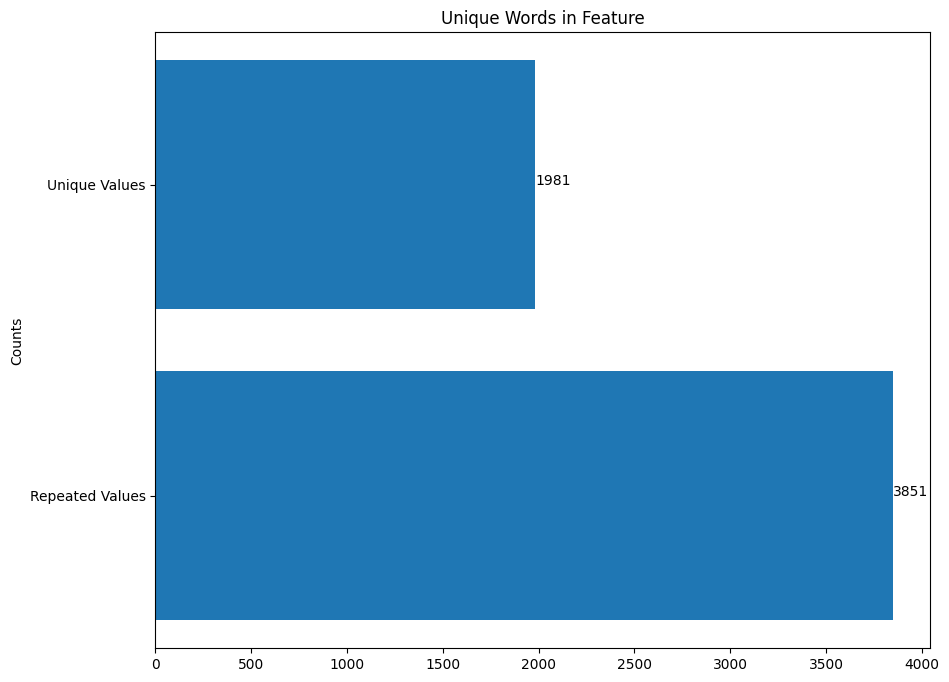

In [36]:
unique_words_features(df.indication)

# Observation :

# How many Unique words and Repeated words in feature ?

* We conclude from above indication features bar plot, total 3851 approx words are repated in indication feature and total 1981 words are unique in feature.


* Repeated words like 'no indication', 'abnormality', 'cardiovarcular', etc. and unique words like 'acute sinusitis', 'altered mental status falling' types of words.

### Words legnth in Feature

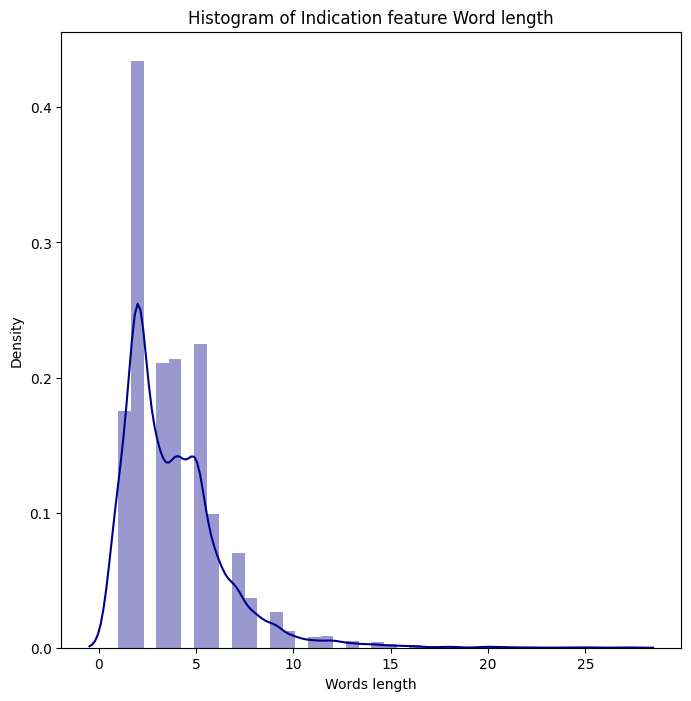

In [37]:
length_indication = df.indication.str.split().str.len()

# plot size
plt.figure(figsize = (8, 8))
      
# seaborn histogram
sns.distplot(length_indication, hist=True, kde=True,bins= 40,
             color = 'Darkblue')

# Add label and title
plt.title('Histogram of Indication feature Word length')
plt.xlabel('Words length')
plt.show()

# Observation :

# How many percentage of data have hight and lower legnth ?

* We observe from above plot, more than 40% of words length are lies between 2-5, 5% words length lies between 5-10.

* Only few words length lies between above  12.

## Count Frequent Words in Feature 

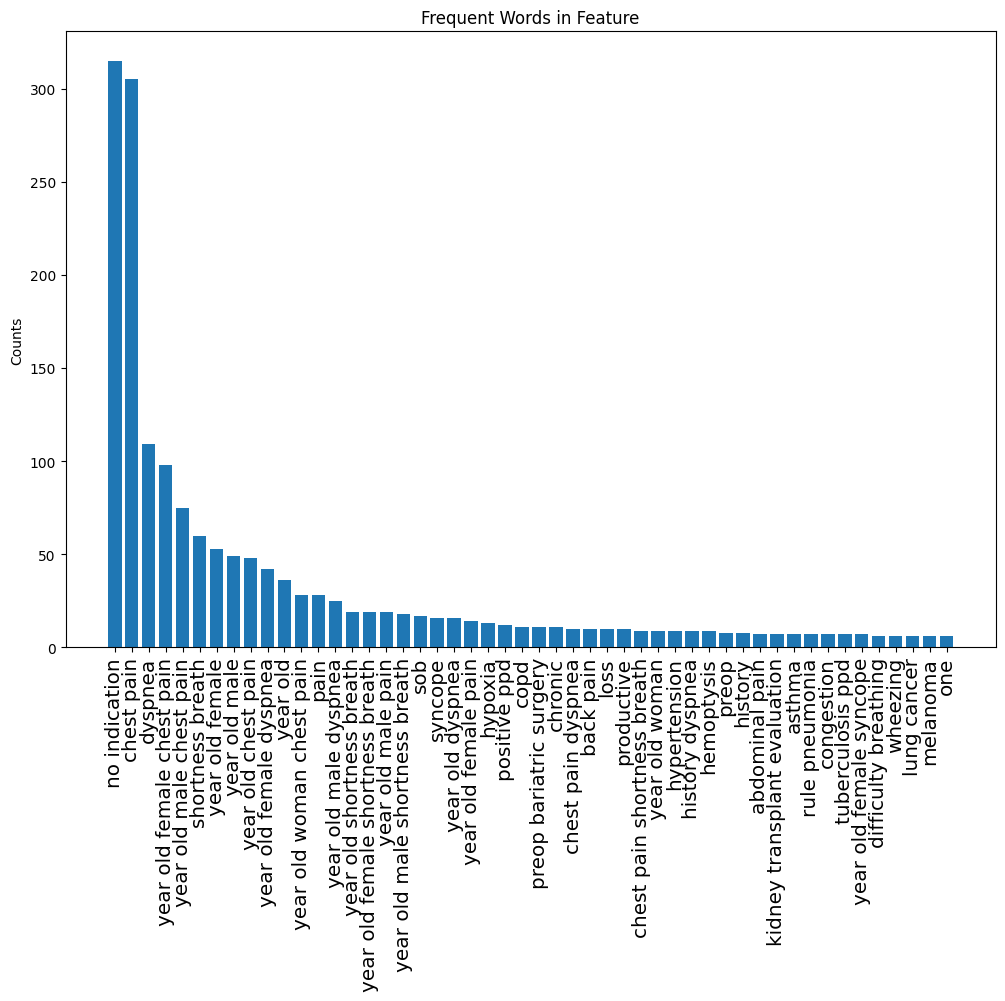

In [38]:
counts = df.indication.value_counts()[:50]

# Plot size
plt.figure(figsize= (12,8))

plt.bar(counts.index, counts.values)
plt.ylabel('Counts')
plt.title('Frequent Words in Feature')
plt.xticks(rotation=90, fontsize='x-large')
plt.show()

# Observation :

# which words are more frequent in feature ?


 * We observe from above plot, plot indicates top 50 frequent words in indication feature. top two most frequent words are 'no indication' and 'chest pain' above 300 counts in feature.
 
 * we observe majority text is chest pain and no indication or patient deatil in indication medical report. 

### CDF of Words length indication feature

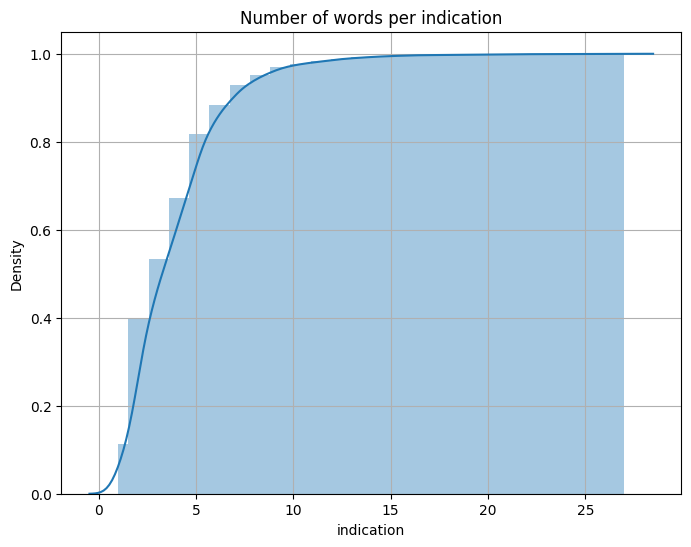

In [39]:
# Change the size of the plot
plt.figure(figsize = (8, 6))

# Seaborn CDF
sns.distplot(length_indication, hist_kws={'cumulative': True, 'density': True}, kde_kws={'cumulative': True})

# Add labels and its range
plt.title('Number of words per indication')
plt.grid()
plt.show()

# Observation :

# What is the 50th, 99th percentile of word length in indication feature ?

* We conclude from above plot, in indication feature 50% data have 7-8 words, 99% text data have less than 10 words in rows. Only 1% data have bove legnth 10.

In [40]:
#https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python

stopwords = (stopwords.words('english')) 
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=1000,
        max_font_size=110, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(18,18))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

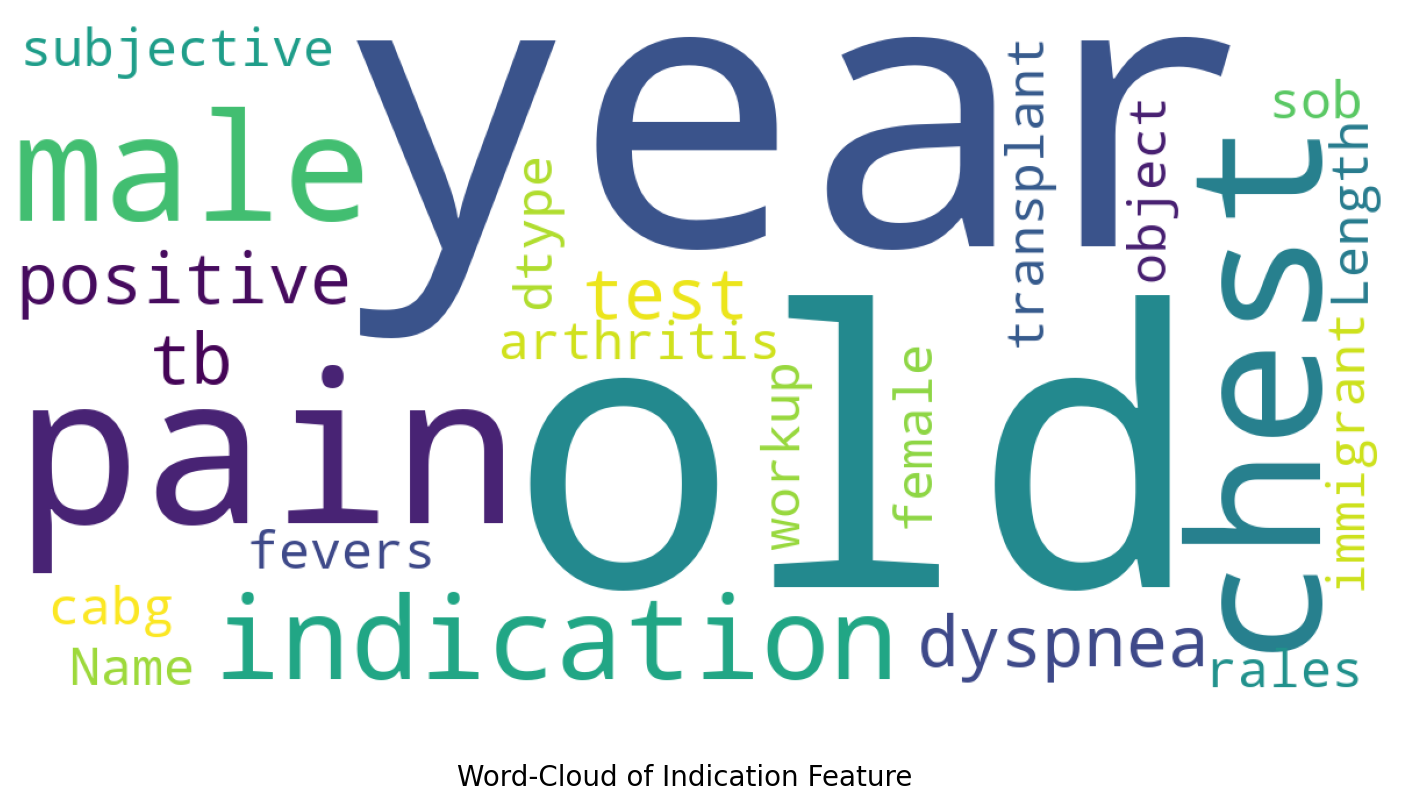

In [41]:
show_wordcloud(df['indication'], title = 'Word-Cloud of Indication Feature')

# Observation :

* Above word cloud are generated on the top 1000 max occurrence words.  

* Year, old, chest, male, indication, tb, positive, female, these are the highlighted words from above visualization, these are important words.

## 2. Analysis of Impression Feature

### Unique words in Feature

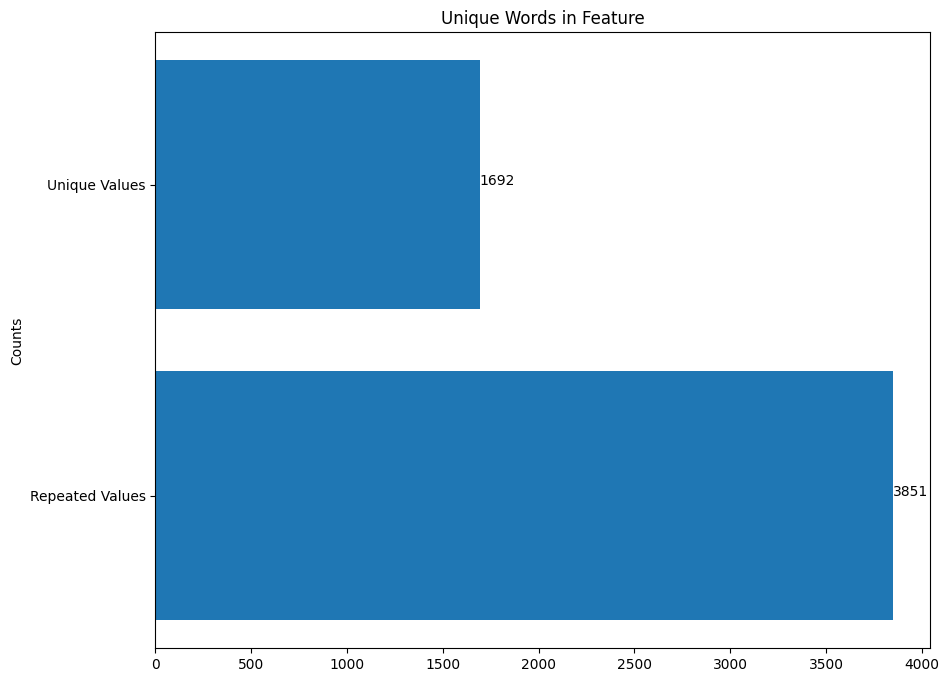

In [42]:
unique_words_features(df.impression)

# Observation :

# How many Unique words and Repeated words in feature ? 

* We conclude from above impression features bar plot, total 3851 approx words are repated in impression feature and total 1692 words are unique in feature.


### Word counts of Feature

In [43]:
length_impression = df.impression.str.split().str.len()

# plot size
plt.figure(figsize = (8, 8))
      
# seaborn histogram
sns.distplot(length_impression, hist=True, kde=True,bins= 40,
             color = 'Darkblue')

# Add label and title
plt.title('Histogram of Impression feature Word len')
plt.xlabel('Words len')
plt.show()

# Observation :

## How many percentage of data have hight and lower legnth ?

* We conclude from above plot, 50% text data length lie between 2-15 and 90% of the data length lies between 2-20.

* 2-10 words length more occurance in impression feature.

* Impression feature text data length more than indication feature, higher and lower value of length in impression feature are 90 words, 2 words respectivaly.

# Count Frequent Words in Feature

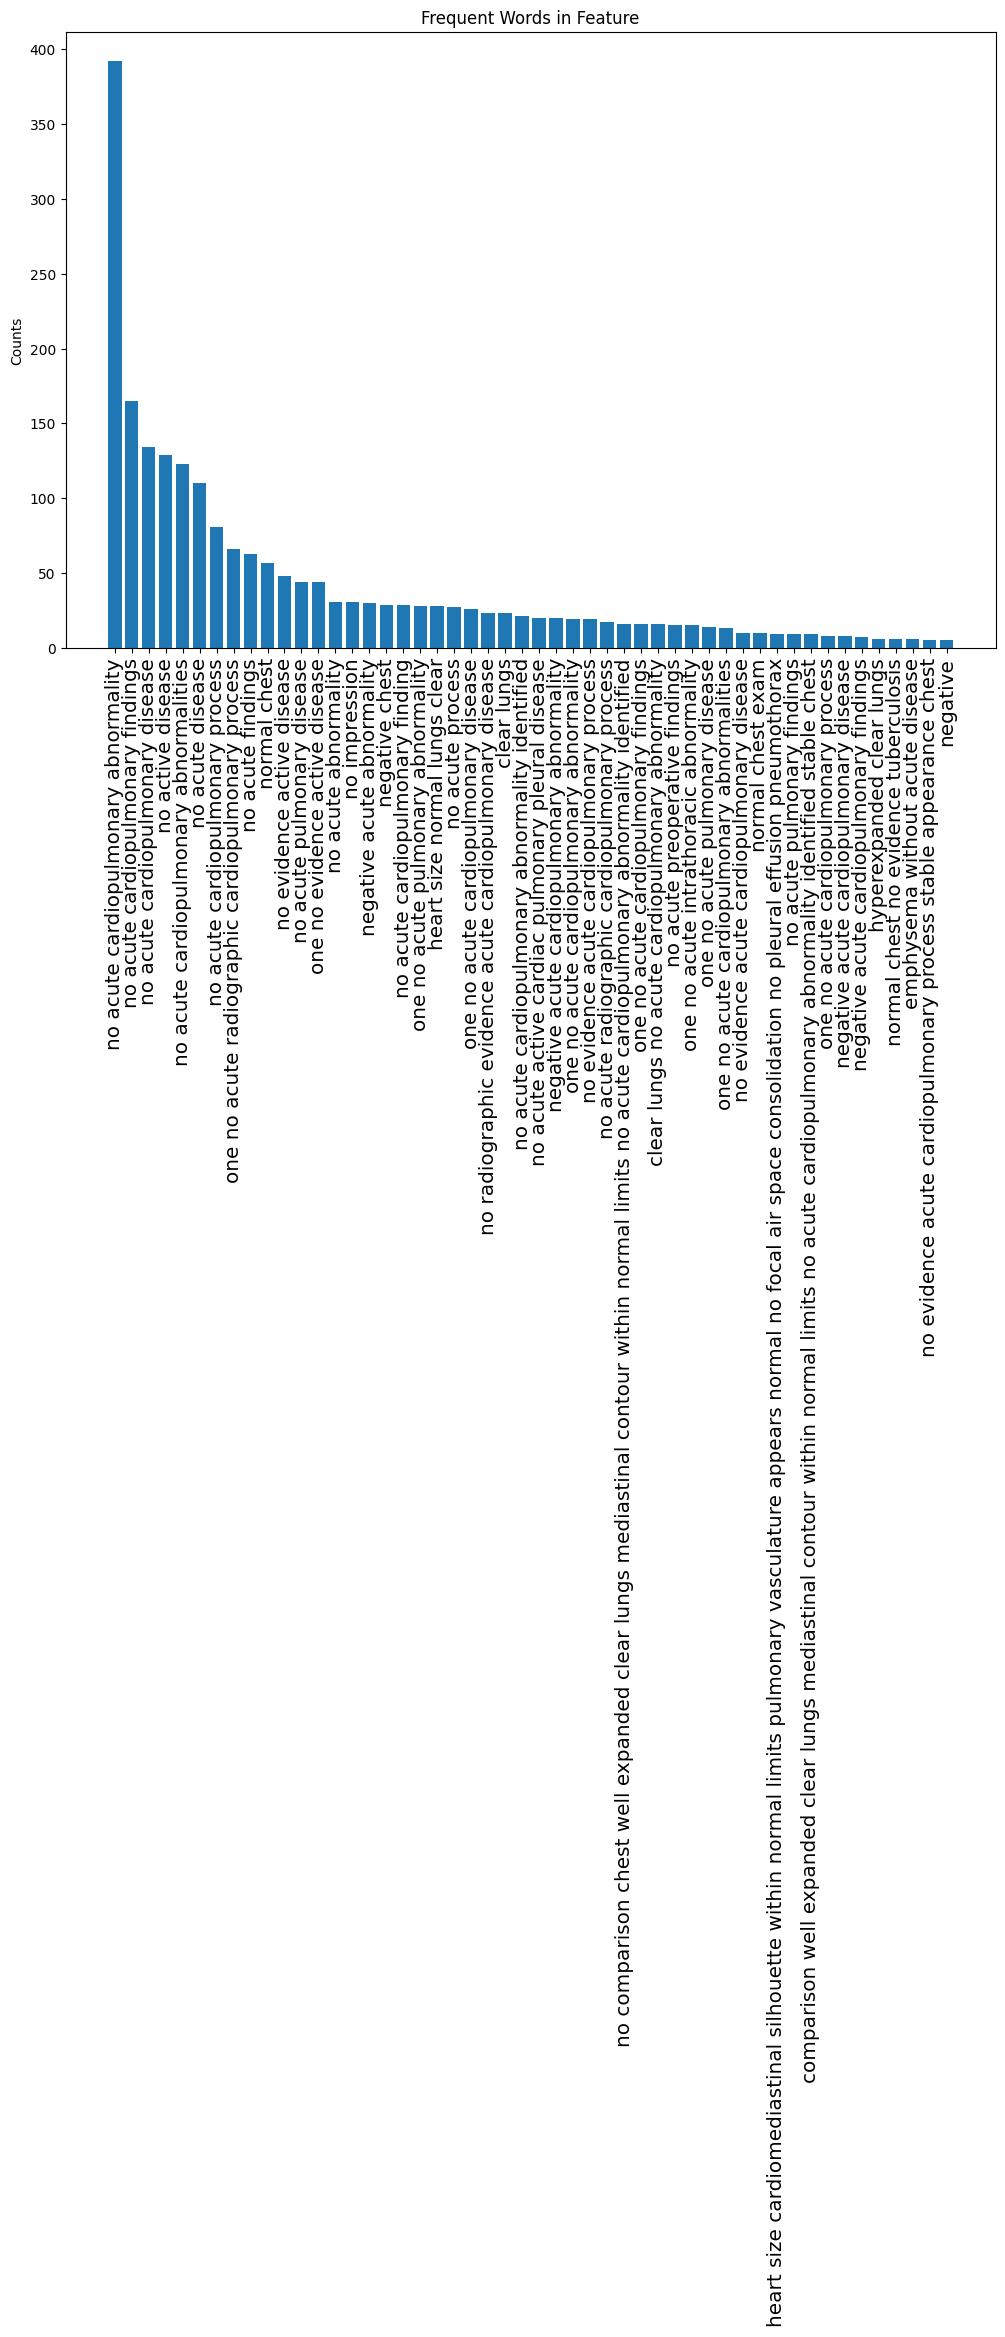

In [44]:
# get the most frequent words in dataframe
counts = df.impression.value_counts()[:50]

# Plot size
plt.figure(figsize= (12,8))

plt.bar(counts.index, counts.values)
plt.ylabel('Counts')
plt.title('Frequent Words in Feature')
plt.xticks(rotation=90, fontsize='x-large')
plt.show()

# Observation :

## which words are more frequent in feature ?
 

 * We observe from above plot, plot indicates top 50 frequent words in impression feature. top two most frequent words are 'no actue cardiopulmonary abnormality' and 'no actue cardiopulmonary findings' above 400 counts in feature.
 
 
 * we observe majority text are 'no actue cardiopulmonary abnormality' and 'no actue cardiopulmonary findings' it means high number patient have no any abnormality, no any diseas.

### CDF of Words length impression feature

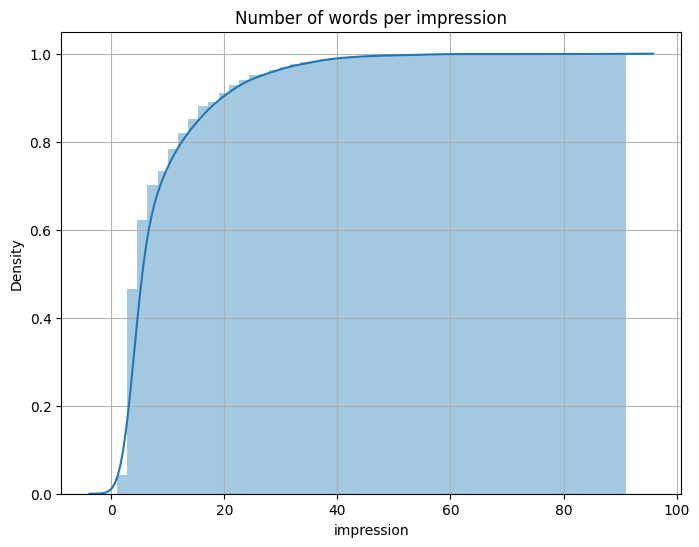

In [45]:
# Change the size of the plot
plt.figure(figsize = (8, 6))

# Seaborn CDF
sns.distplot(length_impression, hist_kws={'cumulative': True, 'density': True}, kde_kws={'cumulative': True})

# Add labels and its range
plt.title('Number of words per impression')
plt.grid()
plt.show()

# Observation : 

## What is the 50th, 99th percentile of word length in indication feature ?

* We conclude from above plot, We see that higher number words in impression. 

* 50% data have less than 4 words per impression, it means only few impression have less words.

* 99% data have less than 39 words per impression.

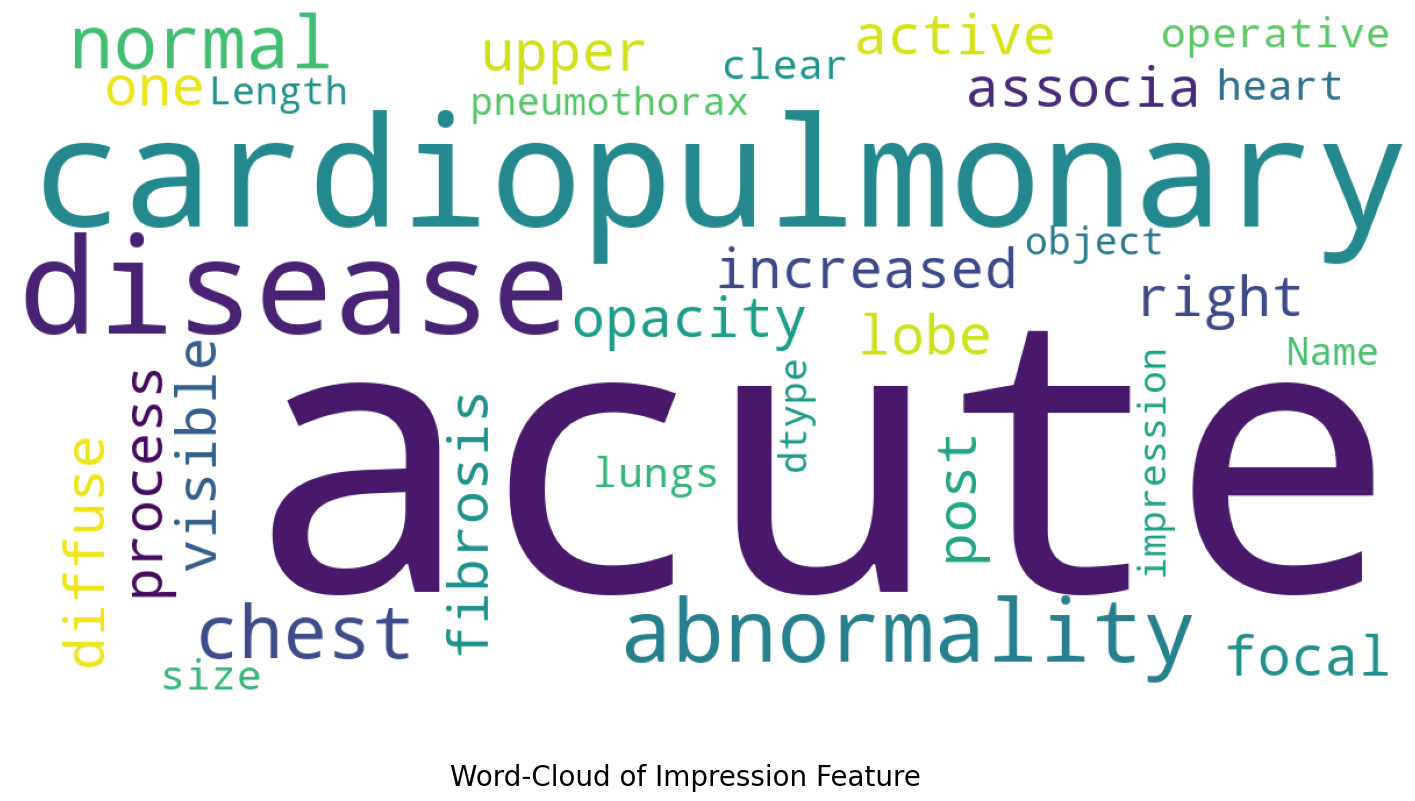

In [46]:
show_wordcloud(df['impression'], title = 'Word-Cloud of Impression Feature')

# Observation :

* Above word cloud are generated on the top 1000 max occurrence words.  

* Acute, disease, abnormality, cardiopulmonary, normal, visible these are the highlighted words from above visualization, these are important words.

# 3. Analysis of Findings Feature

### Unique words in Feature 

In [47]:
unique_words_features(df.findings)

# Observation :

## How many Unique words and Repeated words in feature ? 

* We conclude from above findings features bar plot, total 3851 approx words are repated in findings feature and total 2520 words are unique in feature.


### Word counts of Feature 

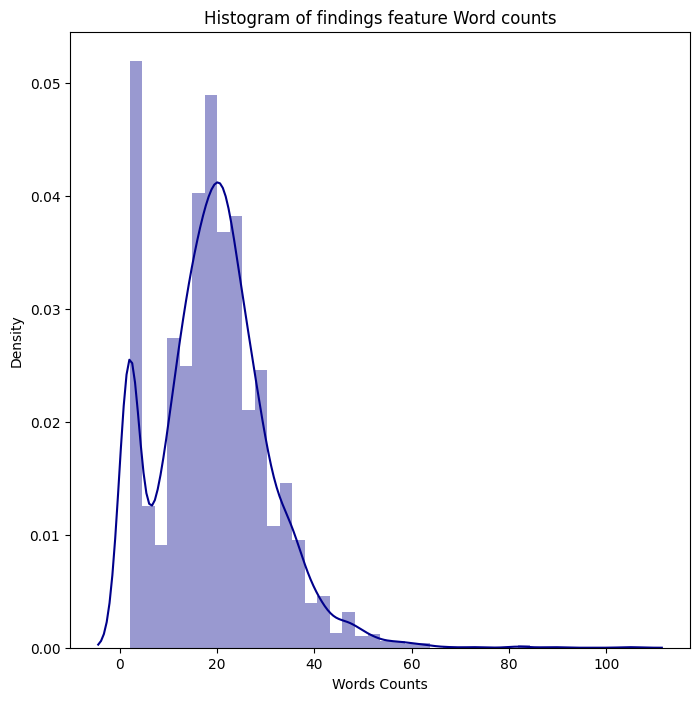

In [48]:
# get the len of the sentence per row
length_findings = df.findings.str.split().str.len()

# plot size
plt.figure(figsize = (8, 8))
      
# seaborn histogram
sns.distplot(length_findings, hist=True, kde=True,bins= 40,
             
             color = 'Darkblue')

# Add label and title
plt.title('Histogram of findings feature Word counts')
plt.xlabel('Words Counts')
plt.show()

# Observation :

## How many percentage of data have hight and lower legnth ?

* 90% data length lies between 5-40 words per findings. some content higher dense in 2-10 words, 10-30 words length content density cross 0.025, some few words cross 80 words per findings. 

### CDF of Findings feature

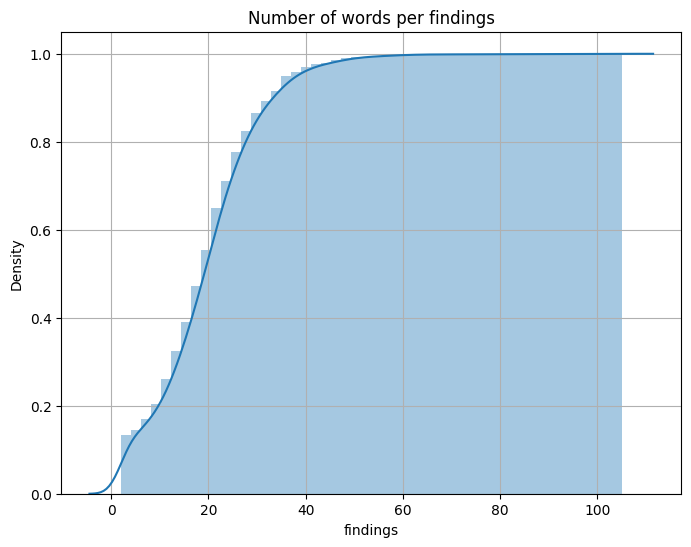

In [49]:
# Change the size of the plot
plt.figure(figsize = (8, 6))

# Seaborn CDF
sns.distplot(length_findings, hist_kws={'cumulative': True, 'density': True}, kde_kws={'cumulative': True})

# Add labels and its range
plt.title('Number of words per findings')
plt.grid()
plt.show()

# Observation : 

## What is the 50th, 99th percentile of word length in indication feature ?

* We conclude from above plot, We see that some fingdings cross 80 words per findings. 

* 50% data have less than 20 words per findings, 99% data have less than 48 words per findings.

In [50]:
show_wordcloud(df['findings'], title = 'Word-Cloud of findings Feature')

# Observation :

* Above word cloud are generated on the top 1000 max occurrence words.  
* Silhouette, mediastinum, within, normal, lungs, cardiomediastinal are the highlighted words from above visualization, these are important words.

# 4. Analysis of Images Feature

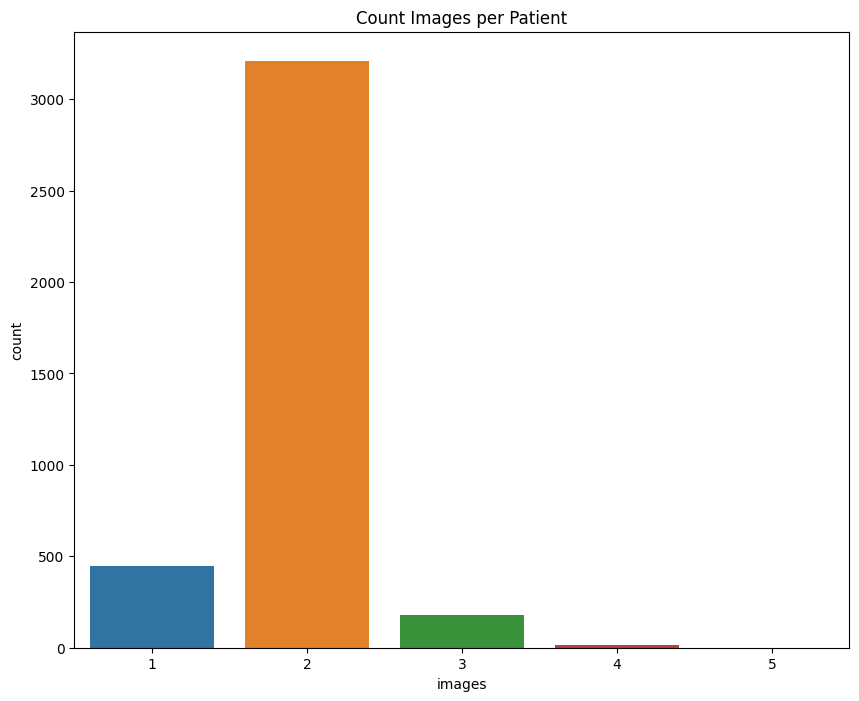

In [51]:
# count the images per patients
image_count = df.images.str.split(',').str.len()

# Plot size
plt.figure(figsize= (10,8))
sns.countplot(image_count)
plt.title('Count Images per Patient')
plt.show()

In [52]:
print('Image Count : ')
print(image_count.value_counts())

Image Count : 
2    3208
1     446
3     181
4      15
5       1
Name: images, dtype: int64


# Observation :

* We can see that above count plot of patient, higher number patients have two chest x - ray images, than one image and than 3 image. Only few patient have 4-5 images of x - ray.


* As per observation we will choose two image per patient, when patient have more than two images we will choose only two and other remove it, if patient have one image of x - ray then we will duplicate first one.


* Total 3208 rows have two images, and lowest value of row is 5 images, so we will convert all more than 2 images two images.  

# 5. Raw Data-Overview

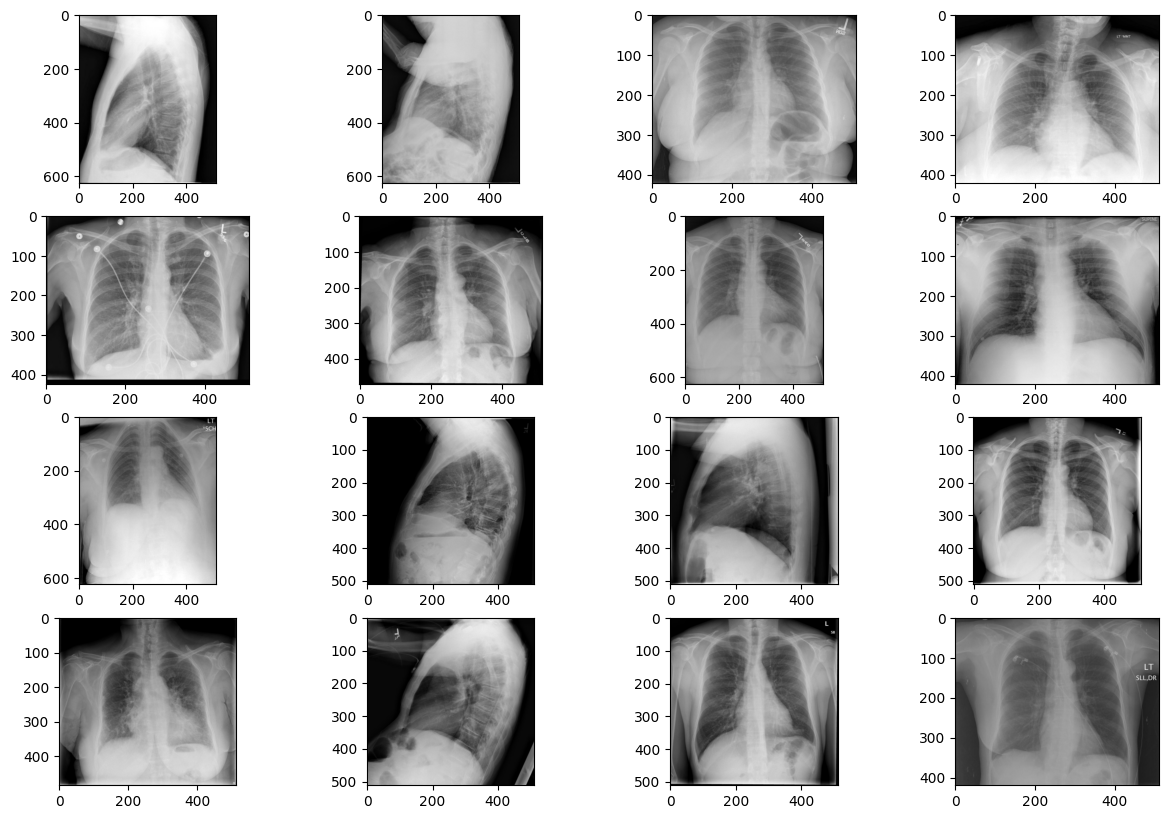

In [55]:
# set the path of image
path = r'C:\Users\srika\Dropbox\PC\Downloads\SendAnywhere_ZHJ56WKR\NLMCXR_png'
os.chdir(path)

# 10 random image index
ix = np.random.randint(low=1, high=100, size=16) 
image = os.listdir()

fig, ax = plt.subplots(4,4, figsize = (15,10))
axs = ax.flatten()              
for i,x in zip(axs, ix) :
    img = mpimg.imread(image[x])
    i.imshow(img) 

plt.show()
os.chdir(r'C:\Users\srika\Dropbox\PC\Downloads\SendAnywhere_ZHJ56WKR')

In [56]:
# Image Data
print('Image data :')
df.images.values.tolist()[1030:1050]

Image data :


['CXR196_IM-0626-1001.png',
 'CXR1960_IM-0627-1002001.png,CXR1960_IM-0627-1003002.png',
 'CXR1961_IM-0628-2001.png,CXR1961_IM-0628-3001.png',
 'CXR1962_IM-0628-2002.png,CXR1962_IM-0628-3003.png',
 'CXR1963_IM-0629-1001.png,CXR1963_IM-0629-2001.png',
 'CXR1964_IM-0629-2001.png,CXR1964_IM-0629-1001.png',
 'CXR1965_IM-0629-2001.png,CXR1965_IM-0629-1001.png',
 'CXR1966_IM-0629-1001.png,CXR1966_IM-0629-1002.png',
 'CXR1967_IM-0629-1001.png,CXR1967_IM-0629-3001.png',
 'CXR1968_IM-0630-4004.png,CXR1968_IM-0630-2001.png',
 'CXR1969_IM-0630-1001.png',
 'CXR197_IM-0631-1001.png,CXR197_IM-0631-1002.png',
 'CXR1970_IM-0632-1001.png,CXR1970_IM-0632-2001.png',
 'CXR1971_IM-0633-2001.png,CXR1971_IM-0633-1001.png',
 'CXR1972_IM-0633-1002.png,CXR1972_IM-0633-1001.png',
 'CXR1973_IM-0633-1001.png,CXR1973_IM-0633-1002.png',
 'CXR1974_IM-0633-2001.png,CXR1974_IM-0633-1001.png',
 'CXR1975_IM-0634-1001.png,CXR1975_IM-0634-2001.png,CXR1975_IM-0634-3001.png',
 'CXR1976_IM-0635-1001-0003.png,CXR1976_IM-0635-10

# Observation : 

* We conclude from above information some rows have two images and some have three images. 

* Total 446 rows have only one image of chest frontal or latral part.


# Image Data Preprocess

In [59]:
# below dataset taken from kaggle 
os.chdir(r'C:\Users\srika\Dropbox\PC\Downloads')
project = pd.read_csv('indiana_projections.csv')

project

uid                   filename projection
0        1     1_IM-0001-4001.dcm.png    Frontal
1        1     1_IM-0001-3001.dcm.png    Lateral
2        2     2_IM-0652-1001.dcm.png    Frontal
3        2     2_IM-0652-2001.dcm.png    Lateral
4        3     3_IM-1384-1001.dcm.png    Frontal
...    ...                        ...        ...
7461  3997  3997_IM-2048-1002.dcm.png    Lateral
7462  3998  3998_IM-2048-1001.dcm.png    Frontal
7463  3998  3998_IM-2048-1002.dcm.png    Lateral
7464  3999  3999_IM-2049-1001.dcm.png    Frontal
7465  3999  3999_IM-2049-2001.dcm.png    Lateral

[7466 rows x 3 columns]

In [60]:
image_1, image_2, impression = [], [], []

for ix,content in tqdm(df.iloc[:, :].iterrows()):
    
    # split the data by comma
    image = content['images'].split(',')
    imp = content['impression']
    
    # if 1 images in row
    if len(image) == 1 :
        image_1.append(image[0])
        image_2.append(image[0])
        impression.append(imp)
        
    # if 2 images in row
    elif len(image) == 2 :
        image_1.append(image[0])
        image_2.append(image[1])
        impression.append(imp)
        
        
    # if 3 images in row        
    elif len(image) == 3 :
        frontal = dict()
        lateral = dict()
        for ix,i in enumerate(image) :
            label = project[project['filename'].str.contains(re.search(r"\d.*\_IM-\d.*\.", i).group())]['projection'].values
            label = "".join(label)
            
            if label == 'Frontal' :
                frontal[ix] = (label)
            elif label == 'Lateral':
                lateral[ix] = (label)
        
        for i in range(2):
            if len(frontal) == 2 :
                image_1.append(image[i])
                image_2.append(image[-1])
                impression.append(imp)
                
            else :
                image_1.append(image[i * 2])
                image_2.append(image[1])
                impression.append(imp)
    
    # if 4 images in row
    elif len(image) == 4 :
        frontal = dict()
        lateral = dict()
        for ix,i in enumerate(image) :
            label = project[project['filename'].str.contains(re.search(r"\d.*\_IM-\d.*\.", i).group())]['projection'].values
            label = "".join(label)
            
            if label == 'Frontal' :
                frontal[i] = (label)
            elif label == 'Lateral':
                lateral[i] = (label)
            
        for i in range(2):
            image_1.append(image[i*1])
            image_2.append(image[3-i])
            impression.append(imp)
                
    # if data point contain 5 images
    elif len(image) == 5 :
        frontal = dict()
        lateral = dict()
        for i in image :
            label = project[project['filename'].str.contains(re.search(r"\d.*\_IM-\d.*\.", i).group())]['projection'].values
            label = "".join(label)
            
            if label == 'Frontal' :
                frontal[i] = (label)
            elif label == 'Lateral':
                lateral[i] = (label)
        
        for i in range(4):
            image_1.append(image[i])
            image_2.append(image[-1])
            impression.append(imp)
            

3851it [00:01, 2666.17it/s]


In [61]:
# check the list len
len(image_1), len(image_2), len(impression)

(4050, 4050, 4050)

# Observation :


* We create final dataframe for the our model, dataset contains three image_1 and image_2 contain x ray image. We converted multipal images into two images. We proceed as follow

1. if data point contain single image, we replicate image and convert into two images.

* 1_frontal ---> 1_frontal, 1_frontal

2. if data point contains two images we separated frontal and lateral lists.

* 1_frontal, 1_lateral --- > 1_frontal, 1_lateral

3. if data point contains three images.

* 1_frontal, 1_lateral, 2_lateral  --- >
* 1_frontal, 1_lateral 
* 1_frontal, 2_lateral  

4. if data point contains four images.

* 1_frontal, 1_lateral, 2_frontal, 2_lateral  --- >

* 1_frontal, 1_lateral 
* 2_frontal, 2_lateral  

5. if data point contains five images.

* 1_frontal, 2_frontal, 3_frontal, 4_frontal, 1_lateral  --- >

* 1_frontal, 1_lateral 
* 2_frontal, 1_lateral  
* 3_frontal, 1_lateral 
* 4_frontal, 1_lateral  


In [62]:
list_1 = [ ]

for x,y,imp in tqdm(zip(image_1, image_2,impression)):
    
    # check the image projection of the different images
    # return frontal or lateral of the given image
    front = project[project['filename'].str.contains(re.search(r"\d.*\_IM-\d.*\.", x).group())]['projection'].values
    later = project[project['filename'].str.contains(re.search(r"\d.*\_IM-\d.*\.", y).group())]['projection'].values
    
    front = "".join(front)
    later = "".join(later)
    
    if (front == 'Lateral') and (later == 'Frontal'):
        list_1.append((y,x,imp))
    else:
        list_1.append((x,y, imp))


4050it [00:17, 230.97it/s]


# Observation :

* As per observation we found some rows have not in frontal and lateral order, so we used projection datasets, projection dataset contains chest x ray images and its projections like image frontal or lateral part.


* Using projection of images, we separated frontal and lateral images and stored in the lists. 

In [63]:
# store values in the the lists
frontal, lateral, impression = [] ,[] ,[]
for i in list_1 :
    frontal.append(i[0])
    lateral.append(i[1])
    impression.append(i[2])

In [64]:
# create the dataframe
last = pd.DataFrame(columns = ['frontal', 'lateral', 'impression'])
last['frontal'] = frontal
last['lateral'] = lateral
last['impression'] = impression

In [65]:
# save the dataframe
last.to_csv('last3.csv')

In [67]:
# set the path of image
path = r'C:\Users\srika\Dropbox\PC\Downloads\SendAnywhere_ZHJ56WKR\NLMCXR_png'
os.chdir(path)

# frontal and lateral images 
image = last.frontal.tolist()[40:60]
image1 = last.lateral.tolist()[40:60]

fig, ax = plt.subplots(5,4, figsize = (15,10))
axs = ax.flatten()
     
for i in range(20):
    img = mpimg.imread(image[i])
    img1 = mpimg.imread(image1[i])
    axs[i].imshow(img) 
    axs[i].imshow(img1)

plt.show()
os.chdir(r'C:\Users\srika\Dropbox\PC\Downloads\SendAnywhere_ZHJ56WKR')

# Data Splitting

In [69]:
final_df = pd.read_csv(r"C:\Users\srika\Dropbox\PC\Downloads\last3.csv")
final_df = final_df.iloc[:,1:]

In [70]:
final_df

frontal                   lateral  \
0      CXR1_1_IM-0001-4001.png   CXR1_1_IM-0001-3001.png   
1       CXR10_IM-0002-2001.png    CXR10_IM-0002-1001.png   
2      CXR100_IM-0002-1001.png   CXR100_IM-0002-2001.png   
3     CXR1000_IM-0003-3001.png  CXR1000_IM-0003-1001.png   
4     CXR1000_IM-0003-1001.png  CXR1000_IM-0003-2001.png   
...                        ...                       ...   
4045   CXR996_IM-2479-1001.png   CXR996_IM-2479-2001.png   
4046   CXR997_IM-2479-1001.png   CXR997_IM-2479-2001.png   
4047   CXR998_IM-2479-1001.png   CXR998_IM-2479-2001.png   
4048   CXR999_IM-2480-1001.png   CXR999_IM-2480-2001.png   
4049   CXR999_IM-2480-3001.png   CXR999_IM-2480-2001.png   

                                             impression  
0                                          normal chest  
1                      no acute cardiopulmonary process  
2                                     no active disease  
3     one increased opacity right upper lobe associa...  
4     one increased opacity right upper lobe associa...  
...                                                 ...  
4045  heart size normal lungs clear no pneumothorax ...  
4046               no acute cardiopulmonary abnormality  
4047               no acute cardiopulmonary abnormality  
4048               no acute cardiopulmonary abnormality  
4049               no acute cardiopulmonary abnormality  

[4050 rows x 3 columns]

In [71]:
train, test  = train_test_split(final_df, test_size = 0.10, random_state = 42, shuffle = True)
train, valid = train_test_split(train, test_size = 0.10, random_state = 42, shuffle = True)


print('train data :', train.shape)
print('test data  :', test.shape)
print('valid data :', valid.shape)

train data : (3280, 3)
test data  : (405, 3)
valid data : (365, 3)


In [72]:
np.unique(final_df.impression).shape

(1692,)

In [74]:
_df = pd.read_csv(r"C:\Users\srika\Dropbox\PC\Downloads\last3.csv")
_df = _df.iloc[:,1:]
np.unique(_df.impression).shape

(1692,)

# Train Data Analysis

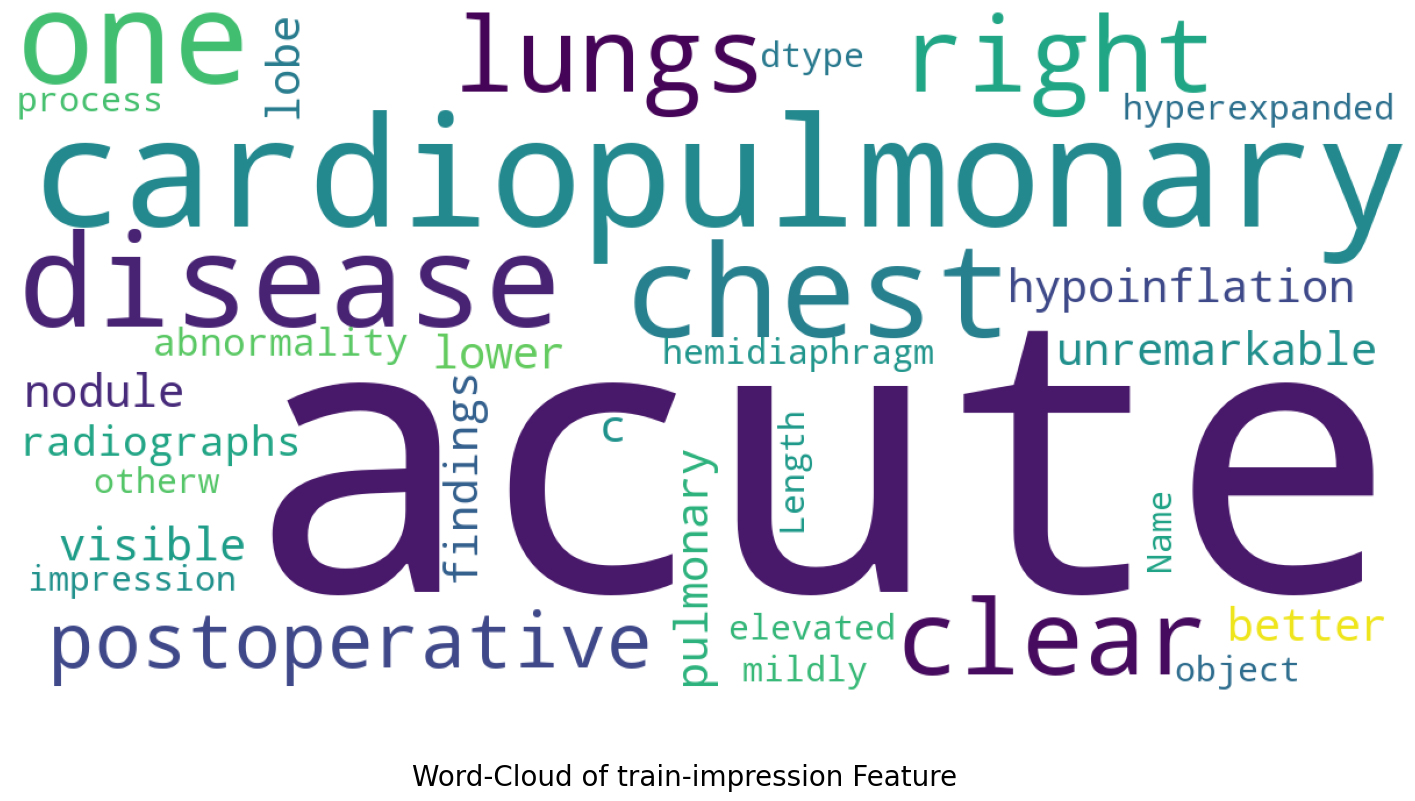

In [75]:
show_wordcloud(train['impression'], title = 'Word-Cloud of train-impression Feature')

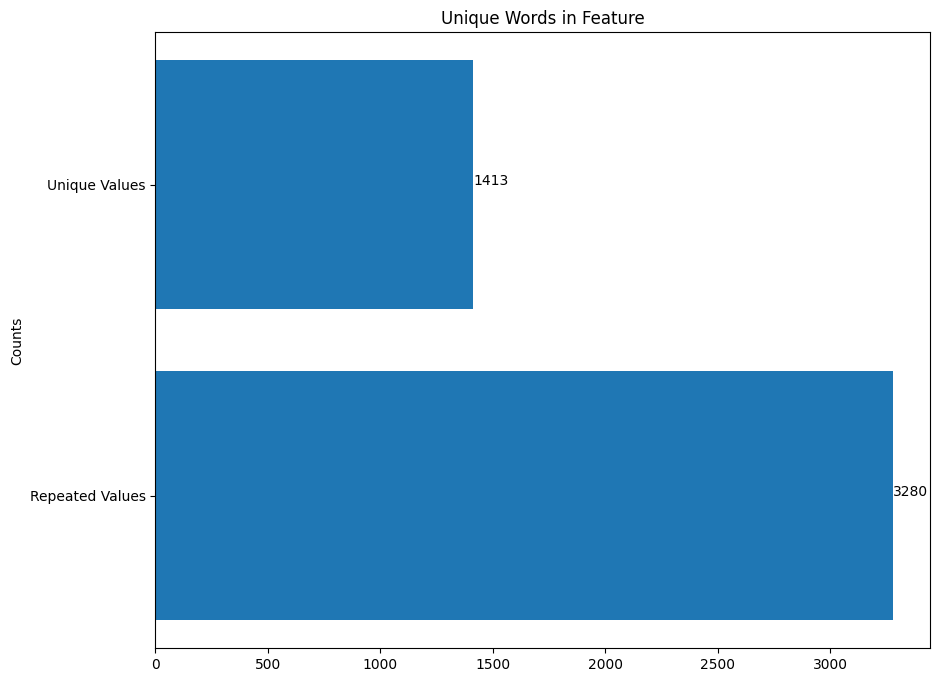

In [76]:
unique_words_features(train.impression)

# Observation Train data :

* We show that wordcloud of train data, some words are acute, lungs, urgent, abnormality, cardiopulmnoary, right impotant words in train data.

* we see that train data have higher number of repeated words than unique words. These unique words usefull for our model vocab.

# Test Data Analysis

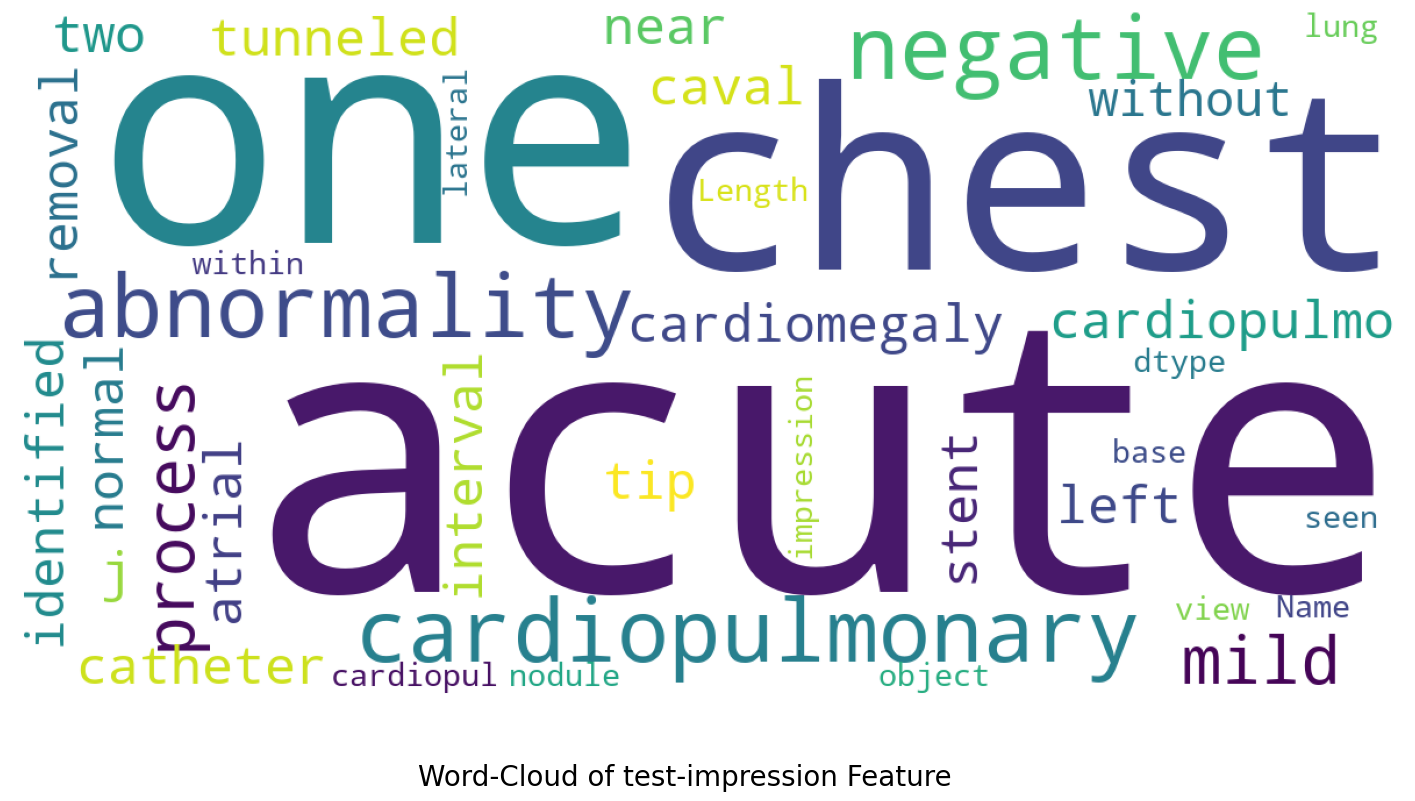

In [77]:
show_wordcloud(test['impression'], title = 'Word-Cloud of test-impression Feature')

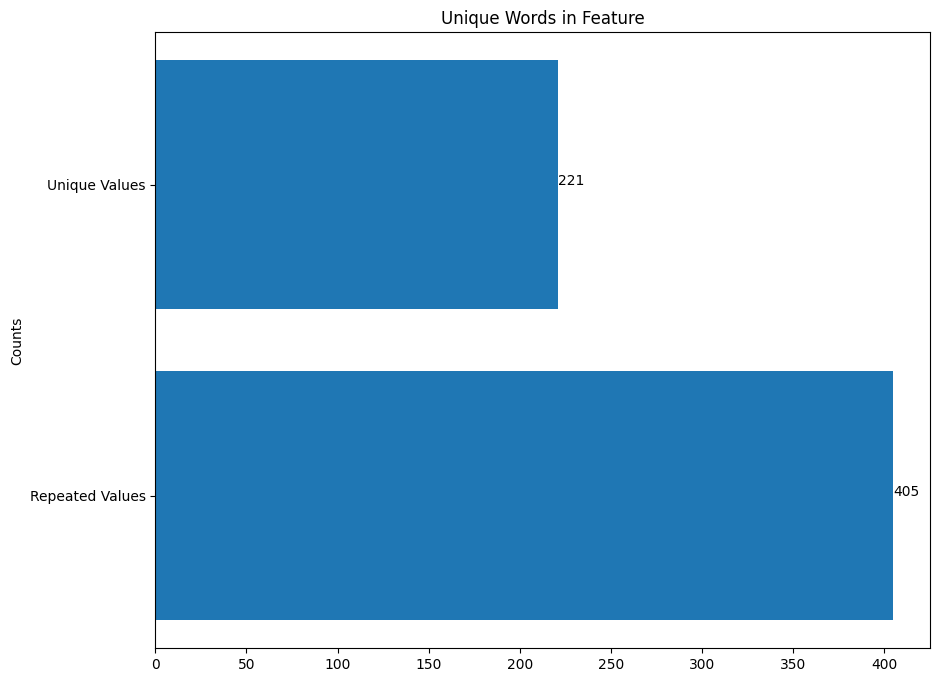

In [78]:
unique_words_features(test.impression)

# Observation Test data :

* We created wordcloud, which words are occurance 1000 times in dataset are important words. acute, findings, disease, abnormality, high, kinds of words.

* Test data contain total 221 unique words and 405 repeated words. We split data into three part train test and validation with 80%, 10% and 10% respectively.

# Validation Data Analysis

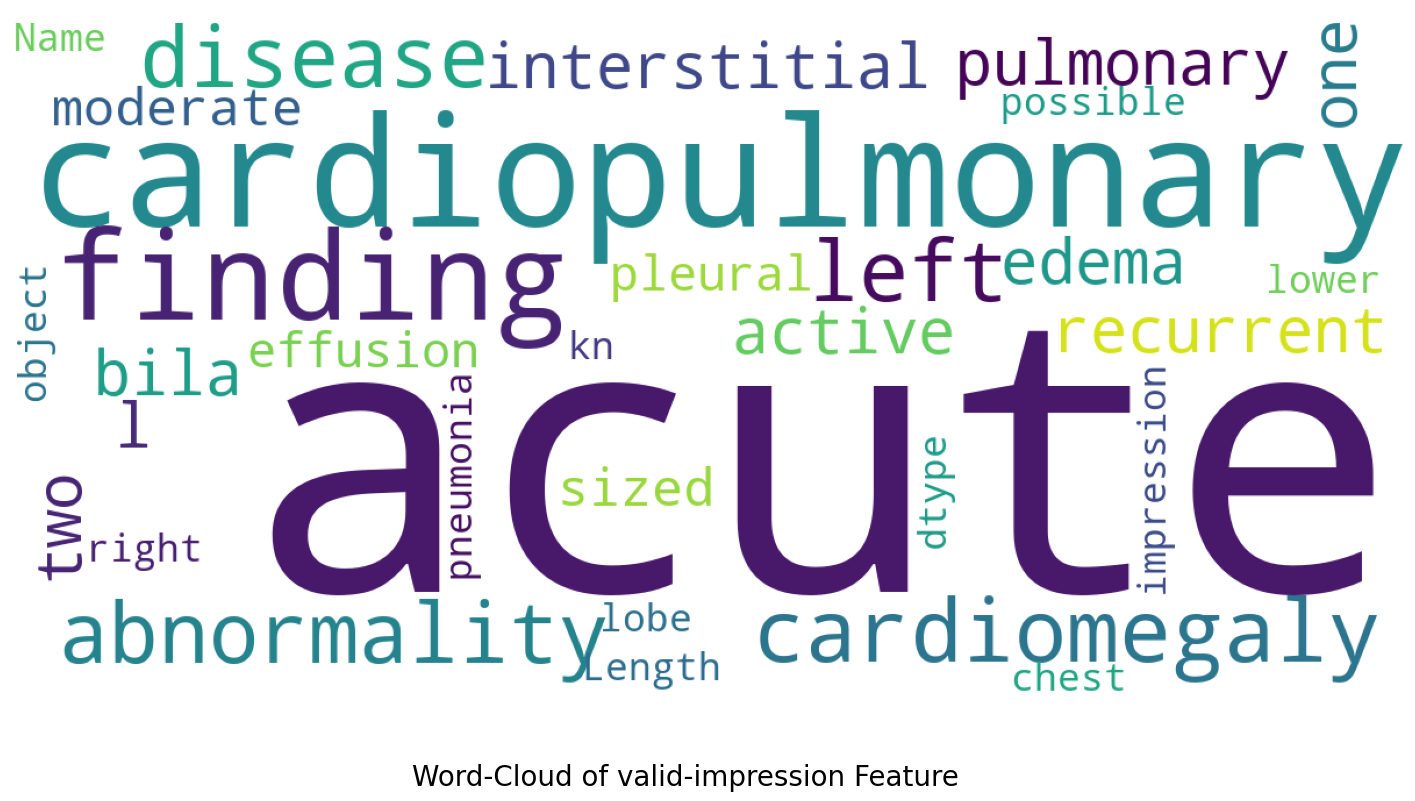

In [79]:
show_wordcloud(valid['impression'], title = 'Word-Cloud of valid-impression Feature')

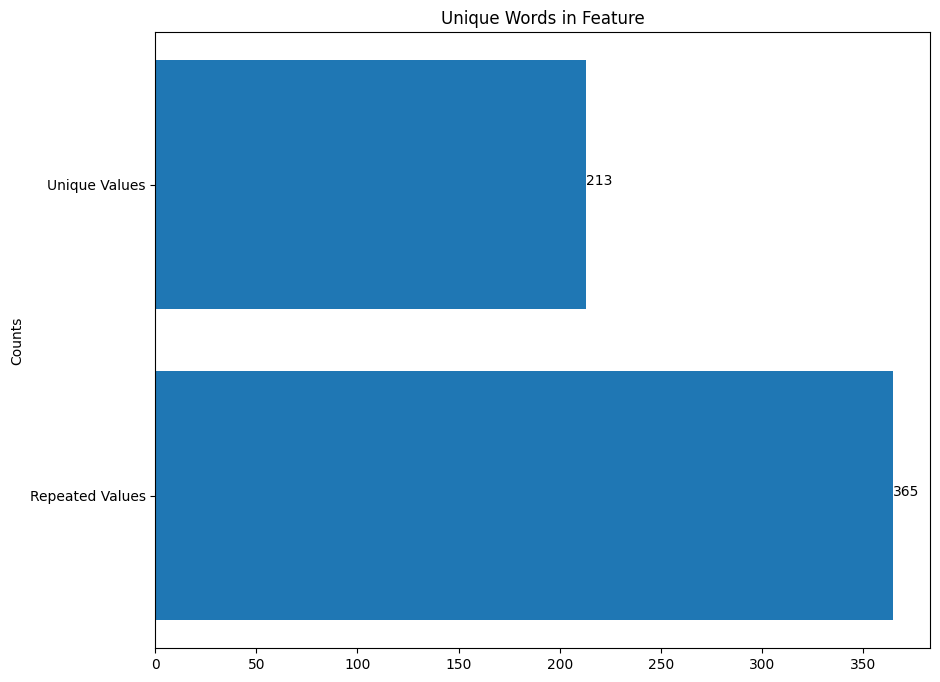

In [80]:
unique_words_features(valid.impression)

# Observation Validation data :

 
 * We created wordcloud, which words are occurance 1000 times in dataset are important words. acute, findings, disease, abnormality, high, right, impression, kinds of words. 
 
 * Some words are frequently present in train, test and validation data like acute, abnormality, disease, right and lungs, these words are most important words in whole datasets.

* Data contain total 213 unique words and 365 repeated words.

# MODEL FOR RECOGNITION

In [103]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Input, Dense, Conv2D, concatenate, Dropout, LSTM, Embedding, Concatenate
from tensorflow.keras.preprocessing.image import img_to_array
#from keras.utils import load_img, img_to_array 
#import keras.utils as image
import os
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm 
import json
import pickle
import cv2
import nltk
from PIL import Image
from keras import Model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import DenseNet121
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
import time
import datetime
import io
import nltk.translate.bleu_score as bleu
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\srika\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [82]:
df_last3 = pd.read_csv(r"C:\Users\srika\Dropbox\PC\Downloads\last3.csv")
df_last3 = df_last3.iloc[: , 1:]
df_last3

frontal                   lateral  \
0      CXR1_1_IM-0001-4001.png   CXR1_1_IM-0001-3001.png   
1       CXR10_IM-0002-2001.png    CXR10_IM-0002-1001.png   
2      CXR100_IM-0002-1001.png   CXR100_IM-0002-2001.png   
3     CXR1000_IM-0003-3001.png  CXR1000_IM-0003-1001.png   
4     CXR1000_IM-0003-1001.png  CXR1000_IM-0003-2001.png   
...                        ...                       ...   
4045   CXR996_IM-2479-1001.png   CXR996_IM-2479-2001.png   
4046   CXR997_IM-2479-1001.png   CXR997_IM-2479-2001.png   
4047   CXR998_IM-2479-1001.png   CXR998_IM-2479-2001.png   
4048   CXR999_IM-2480-1001.png   CXR999_IM-2480-2001.png   
4049   CXR999_IM-2480-3001.png   CXR999_IM-2480-2001.png   

                                             impression  
0                                          normal chest  
1                      no acute cardiopulmonary process  
2                                     no active disease  
3     one increased opacity right upper lobe associa...  
4     one increased opacity right upper lobe associa...  
...                                                 ...  
4045  heart size normal lungs clear no pneumothorax ...  
4046               no acute cardiopulmonary abnormality  
4047               no acute cardiopulmonary abnormality  
4048               no acute cardiopulmonary abnormality  
4049               no acute cardiopulmonary abnormality  

[4050 rows x 3 columns]

In [84]:
train.to_csv(r'C:\Users\srika\Dropbox\PC\Downloads\SendAnywhere_ZHJ56WKR\train.csv')
test.to_csv(r'C:\Users\srika\Dropbox\PC\Downloads\SendAnywhere_ZHJ56WKR\test.csv')
valid.to_csv(r'C:\Users\srika\Dropbox\PC\Downloads\SendAnywhere_ZHJ56WKR\valiation.csv')

In [86]:
train = pd.read_csv(r'C:\Users\srika\Dropbox\PC\Downloads\SendAnywhere_ZHJ56WKR\train.csv')
test = pd.read_csv(r'C:\Users\srika\Dropbox\PC\Downloads\SendAnywhere_ZHJ56WKR\test.csv')
validation = pd.read_csv(r'C:\Users\srika\Dropbox\PC\Downloads\SendAnywhere_ZHJ56WKR\valiation.csv')

train = train.iloc[:, 1:]
test = test.iloc[:, 1:]
validation = validation.iloc[:, 1:]

print("train data -     ",train.shape)
print('test data -      ',test.shape)
print('validation data -',validation.shape)

train data -      (3280, 3)
test data -       (405, 3)
validation data - (365, 3)


In [87]:
# Ad start and end token in datasets

train.impression      = '<start> ' + train.impression + ' <end>'
validation.impression = '<start> ' + validation.impression + ' <end>'
test.impression       = '<start> ' + test.impression + ' <end>'

In [88]:
train.head()

frontal                   lateral  \
0   CXR251_IM-1032-3001.png   CXR251_IM-1032-4001.png   
1   CXR976_IM-2464-1001.png   CXR976_IM-2464-2001.png   
2  CXR2715_IM-1180-1001.png  CXR2715_IM-1180-2001.png   
3  CXR1583_IM-0378-1001.png  CXR1583_IM-0378-3001.png   
4  CXR2376_IM-0936-1001.png  CXR2376_IM-0936-2001.png   

                                          impression  
0                     <start> no acute disease <end>  
1  <start> postoperative chest hypoinflation no v...  
2  <start> one right lower lobe pulmonary nodule ...  
3    <start> no acute cardiopulmonary findings <end>  
4       <start> unremarkable radiographs chest <end>

In [89]:
validation.head()

frontal                   lateral  \
0   CXR227_IM-0859-12012.png   CXR227_IM-0859-4004.png   
1  CXR1768_IM-0502-13013.png  CXR1768_IM-0502-3003.png   
2   CXR2108_IM-0738-1001.png  CXR2108_IM-0738-1002.png   
3   CXR3380_IM-1628-1001.png  CXR3380_IM-1628-2001.png   
4   CXR1514_IM-0333-1001.png  CXR1514_IM-0333-2001.png   

                                          impression  
0  <start> cardiomegaly pulmonary interstitial ed...  
1  <start> no acute cardiopulmonary abnormality <...  
2                    <start> no active disease <end>  
3     <start> no acute cardiopulmonary disease <end>  
4  <start> one no acute cardiopulmonary abnormali...

## Inception-V3 (pre-trained model)

In [92]:
 # used pre trained inception model 
  
model = InceptionV3(include_top=False, weights='imagenet', pooling='avg')
input_layer  = model.input
output_layer = model.layers[-1].output

image_model = tf.keras.Model(input_layer, output_layer)
image_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                           

In [93]:
# shape of the input and output layer
input_layer, output_layer

(<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'global_average_pooling2d_1')>)

In [94]:
image_1 = Input(shape=(256,256,3),name="image_1_features")
image_2 = Input(shape=(256,256,3),name="image_2_features")

# call the inception v3 model
image_1_out = image_model(image_1)
image_2_out = image_model(image_2)

merge = concatenate((image_1_out,image_2_out),axis=-1,name="final_image_features")
model = Model(inputs=[image_1,image_2],outputs= merge)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_1_features (InputLayer)  [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 image_2_features (InputLayer)  [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 2048)         21802784    ['image_1_features[0][0]',       
                                                                  'image_2_features[0][0]'] 

### Conclusion

* We used pre-trained inception-v3 model for the our Encoder task. Inception model is used for the classification task, we modified inception model for the our use.

* We removed last layer of the model for our use. Then we created one extra model. it will take two x ray images and return concate tensor of two diffrent image's tensors. 

# Preprocess of image data and text data 

In [115]:
def preprocess(image_path1, image_path2, path):
    '''
    input -- image 1 , image 2, image's path
    output -- image tensor
    process - convert two images into 256 X 256, then using inception model generate tensor (concate two image tensor)


    '''

    # join path and image name 
    image_path1 = path + image_path1
    image_path2 = path + image_path2
    
    # load the images
    img1 = tf.keras.utils.load_img(image_path1, target_size=(256,256))
    img2 = tf.keras.utils.load_img(image_path2, target_size=(256,256))

    # Convert PIL image to numpy array of 3-dimensions
    x1 = tf.keras.utils.img_to_array(img1)
    x2 = tf.keras.utils.img_to_array(img2)

    # Add one more dimension
    x1 = np.expand_dims(x1, axis=0)
    x2 = np.expand_dims(x2, axis=0)

    # preprocess the images using preprocess_input() from inception module
    x1 = preprocess_input(x1)
    x2 = preprocess_input(x2)
    
    # create tensor
    tensor = model([x1,x2])
    
    return tensor

In [116]:
from tensorflow.keras.utils import load_img

In [117]:
# create the tensor using train and validation data and store it in list

path = 'C:/Users/srika/Dropbox/PC/Downloads/SendAnywhere_ZHJ56WKR/NLMCXR_png/'

# train data
image_train = [ ]
for col in tqdm(train.values):
    tensor = preprocess(col[0], col[1], path)
    image_train.append(tensor)

# validation data
image_validation = [ ]
for col in tqdm(validation.values):
    tensor = preprocess(col[0], col[1], path)
    image_validation.append(tensor)

print(f'shape of the train and validation image list are {len(image_train)} and  {len(image_validation)}')
print(f'shape of the train and validation image tensor are {image_train[0].shape} and  {image_validation[0].shape}')

  0%|          | 0/3280 [00:00<?, ?it/s]

  0%|          | 0/365 [00:00<?, ?it/s]

shape of the train and validation image list are 3280 and  365
shape of the train and validation image tensor are (1, 4096) and  (1, 4096)


In [118]:
image_train[0]

<tf.Tensor: shape=(1, 4096), dtype=float32, numpy=
array([[0.57642376, 1.0254263 , 0.12115335, ..., 0.44638294, 0.13633981,
        2.1809223 ]], dtype=float32)>

In [119]:
image_validation[0]

<tf.Tensor: shape=(1, 4096), dtype=float32, numpy=
array([[0.86020404, 0.2975438 , 0.28898436, ..., 0.7923191 , 0.37731206,
        1.0407308 ]], dtype=float32)>

In [120]:
for i in [image_train, image_validation]:
    print(len(i))

3280
365


In [122]:
# save the tensor in numpy format
np.save("C:/Users/srika/Dropbox/PC/Downloads/SendAnywhere_ZHJ56WKR/train_image_features_3", image_train)
np.save("C:/Users/srika/Dropbox/PC/Downloads/SendAnywhere_ZHJ56WKR/validation_image_features_3",  image_validation) 

In [125]:
image_train = np.load('C:/Users/srika/Dropbox/PC/Downloads/SendAnywhere_ZHJ56WKR/train_image_features_3.npy')
image_validation = np.load('C:/Users/srika/Dropbox/PC/Downloads/SendAnywhere_ZHJ56WKR/validation_image_features_3.npy')

## Text data convert into tokens

In [126]:
token = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^`{|}~\t\n')

# sequence in train, test and validation 
token.fit_on_texts(train['impression'])
token_train       = token.texts_to_sequences(train['impression'])
token_val         = token.texts_to_sequences(validation['impression'])
print('Vocab size - ', len(token.word_index))

# padding in the train, test and validation 
max_len = 60
pad_train = pad_sequences(token_train, maxlen = max_len, dtype='int32', padding='post', truncating='post')
pad_val   = pad_sequences(token_val,   maxlen = max_len, dtype='int32', padding='post', truncating='post')
print(pad_train[:1])

word_idx = {}
idx_word = {}
for k, v in (token.word_index).items(): 
    word_idx[k] = v
    idx_word[v] = k
    
vocab_size = len(word_idx)+1

Vocab size -  1312
[[1 3 4 6 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


## Emebdding Matrix

In [128]:
# Create embedding matrix

list_sents = [ ]
for sent_tok in train.impression :
    for sent in nltk.sent_tokenize(sent_tok) :
        # replace start and end token, otherwise list_sent got like  <, start ,> 

        sent = sent.replace('<start>', "")
        sent = sent.replace('<end>', "")

        list_sents.append(['<start>' , *nltk.word_tokenize(sent) , '<end>'])
        

w2v = Word2Vec(sentences= list_sents, vector_size=300, window=5, min_count=1, workers=4)

In [129]:
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tqdm(token.word_index.items()):
  embedding_vector = w2v.wv[word]
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

  0%|          | 0/1312 [00:00<?, ?it/s]

In [130]:
embedding_matrix.shape

(1313, 300)

In [131]:
#we prepare the data set with the image fetaures and the reports
# https://www.tensorflow.org/tutorials/text/image_captioning

batch_size = 20

train_dataset = tf.data.Dataset.from_tensor_slices((image_train, pad_train))
train_dataset = train_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((image_validation, pad_val))
val_dataset = val_dataset.shuffle(500).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [132]:
for i,j in train_dataset :
    print(i,j)
    break

tf.Tensor(
[[[0.23371595 0.295152   0.29652002 ... 0.784683   0.06476213 0.39143974]]

 [[1.2724185  0.3653686  0.26266372 ... 0.22607763 0.03663239 0.61432844]]

 [[0.5404386  0.48701605 0.08455458 ... 0.02032704 0.         1.1048548 ]]

 ...

 [[0.7292298  0.05489119 0.2023537  ... 0.50713897 0.2711214  0.9213272 ]]

 [[0.41918552 1.4114382  0.8908274  ... 0.5165258  0.3096882  0.99857074]]

 [[0.2528235  0.29893863 0.04952693 ... 1.2072222  0.25999868 1.2454203 ]]], shape=(20, 1, 4096), dtype=float32) tf.Tensor(
[[  1 116  28 ...   0   0   0]
 [  1  44   4 ...   0   0   0]
 [  1   3   4 ...   0   0   0]
 ...
 [  1   7  15 ...   0   0   0]
 [  1  44   4 ...   0   0   0]
 [  1  64  51 ...   0   0   0]], shape=(20, 60), dtype=int32)


In [133]:
for i,j in val_dataset :
    print(i,j)
    break

tf.Tensor(
[[[0.63547397 0.7401246  0.36333886 ... 0.6374839  0.17174195 0.706526  ]]

 [[0.44740832 1.1418943  0.35894734 ... 0.58565843 0.6988685  0.8374936 ]]

 [[0.60888356 0.2831236  0.35641867 ... 0.6453648  0.1428458  0.6423381 ]]

 ...

 [[0.29880705 0.06261027 0.23513144 ... 0.18914029 0.         1.0837126 ]]

 [[0.62453645 0.13570924 0.09185616 ... 1.0637724  0.26046777 1.2240216 ]]

 [[0.6489623  0.48639065 0.04485611 ... 0.8152548  0.43507406 2.0690532 ]]], shape=(20, 1, 4096), dtype=float32) tf.Tensor(
[[ 1  7 55 ...  0  0  0]
 [ 1  3  4 ...  0  0  0]
 [ 1 22 23 ...  0  0  0]
 ...
 [ 1  3  4 ...  0  0  0]
 [ 1 44 15 ...  0  0  0]
 [ 1 28  3 ...  0  0  0]], shape=(20, 60), dtype=int32)


## Model

In [134]:
# image input
input_layer = Input(shape=(1,4096), name = 'Image input')
encoder_out = Dense(300, name = 'image_dense')(input_layer)

input_layer_text = tf.keras.layers.Input(shape=(1,), name = 'text inout')
x = Embedding(input_dim = vocab_size, output_dim=300, input_length=max_len, mask_zero=True, trainable=False, weights=[embedding_matrix])(input_layer_text)
x = Concatenate()([x, encoder_out])
x = LSTM(512, return_sequences= True)(x)
x = Dense(vocab_size)(x)
model1 = Model([input_layer, input_layer_text],x)
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text inout (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Image input (InputLayer)       [(None, 1, 4096)]    0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 300)       393900      ['text inout[0][0]']             
                                                                                                  
 image_dense (Dense)            (None, 1, 300)       1229100     ['Image input[0][0]']            
                                                                                            

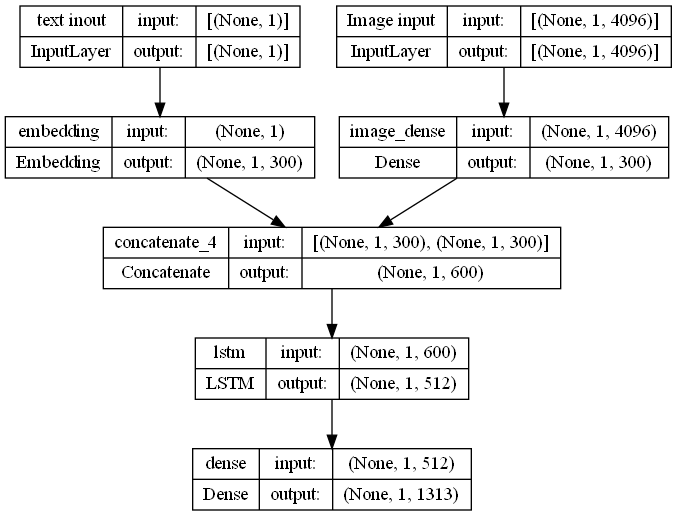

In [135]:
tf.keras.utils.plot_model(model1, to_file='model_1_plot.png', show_shapes=True, show_layer_names=True)

# Encoder and Decoder

## Encoder

In [136]:
 class Encoder(tf.keras.Model) :
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.dense = Dense(units= self.embedding_dim, kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 40), name = 'encoder_dense_layer')
    
    def call(self, x):
        
        x = self.dense(x)
        x = tf.nn.relu(x)

        return x

## Decoder

In [137]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, lstm_units, vocab_size):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.lstm_units = lstm_units

        self.embedding = Embedding(self.vocab_size, self.embedding_dim, mask_zero=True, trainable=False, weights=[embedding_matrix], name = 'Decoder_embedding')
        self.lstm     = LSTM(self.lstm_units, return_sequences= True, 
                             return_state= True, 
                             kernel_initializer = tf.keras.initializers.glorot_uniform(seed = 40),
                             name = 'decoder_lstm')
        
        self.dense    = Dense(self.vocab_size, name = 'Decoder_dense')

        
    def call(self, x, image_features) :

        x = self.embedding(x)
        x = tf.concat([x, image_features], axis=-1)
        output, state, _ = self.lstm(x)
        x = self.dense(output)

        return x


## Loss function

In [138]:
# https://www.tensorflow.org/tutorials/text/image_captioning

optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
acc_obj = tf.keras.metrics.SparseCategoricalAccuracy()

@tf.function
def  loss_func(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

  
def acc_func(real, pred):
    acc_f = acc_obj(real, pred)
    return tf.reduce_mean(acc_f)


## Data Loader and Model

In [139]:
embedding_dim = 300
encoder = Encoder(embedding_dim = embedding_dim)

lstm_units = 600
decoder = Decoder(embedding_dim = embedding_dim, lstm_units = lstm_units , vocab_size = vocab_size)

In [174]:
@tf.function
def train_step(tensor, target):
    global train_acc
    loss    = 0
    train_acc = 0
    
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(tensor)

        for i in range(1, target.shape[1]):         
            predictions = decoder(dec_input, features)
            loss += loss_func(target[:, i], predictions)
            train_acc += acc_func(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i],1)
       
    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

###################################################################################

#validation function
@tf.function
def val_step(tensor, target):
    loss_val = 0
    global test_acc
    test_acc = 0
    dec_input = tf.expand_dims([token.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(tensor)

        for i in range(1, target.shape[1]):
            predictions_val = decoder(dec_input, features)
            loss_val += loss_func(target[:, i], predictions_val)
            test_acc += acc_func(target[:, i], predictions_val)
            dec_input = tf.expand_dims(target[:, i],1)
        
    total_loss_val = (loss_val / int(target.shape[1]))

    return loss_val, total_loss_val

In [175]:
tf.keras.backend.clear_session()
EPOCHS = 50

loss_plot_train = []
loss_plot_val = []
num_steps = 64

for epoch in (range(0, EPOCHS)):

    start = time.time()
    total_loss_train = 0
    total_loss_val   = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss= train_step(img_tensor, target)
        total_loss_train += t_loss

    loss_plot_train.append(total_loss_train / num_steps)

    for (batch, (img_tensor, target)) in enumerate(val_dataset) :
        batch_loss, t_loss = val_step(img_tensor, target)
        total_loss_val += t_loss
  

    loss_plot_val.append(total_loss_val / num_steps)

    print('Epoch {} Train Loss : {:.6f}   Test Loss : {:.6f}'.format(epoch + 1, total_loss_train / num_steps, total_loss_val / num_steps))
    print('Time taken for epoch {} sec\n'.format(time.time() - start))

Epoch 1 Train Loss : 1.216222   Test Loss : 0.134604
Time taken for epoch 120.45889735221863 sec

Epoch 2 Train Loss : 1.082405   Test Loss : 0.117989
Time taken for epoch 62.286508321762085 sec

Epoch 3 Train Loss : 0.976045   Test Loss : 0.114915
Time taken for epoch 63.25546360015869 sec

Epoch 4 Train Loss : 0.907937   Test Loss : 0.105066
Time taken for epoch 64.50806379318237 sec

Epoch 5 Train Loss : 0.862365   Test Loss : 0.106504
Time taken for epoch 65.36184072494507 sec

Epoch 6 Train Loss : 0.820877   Test Loss : 0.097468
Time taken for epoch 64.58843684196472 sec

Epoch 7 Train Loss : 0.800795   Test Loss : 0.099018
Time taken for epoch 62.97211146354675 sec

Epoch 8 Train Loss : 0.774740   Test Loss : 0.102066
Time taken for epoch 62.34383177757263 sec

Epoch 9 Train Loss : 0.759052   Test Loss : 0.094359
Time taken for epoch 64.99576449394226 sec

Epoch 10 Train Loss : 0.745804   Test Loss : 0.093968
Time taken for epoch 63.90978741645813 sec

Epoch 11 Train Loss : 0.727

In [176]:
plt.plot(loss_plot_train, label = 'Train loss')
plt.plot(loss_plot_val, label = 'Test Loss')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Prediction

In [177]:
def evaluate(image1, image2, path):
    '''
    Input - two image and image path
    output - return medical report of the images
    This function taek images and using encoder decoder model
    and return medical report of the images
    
    '''

    img_tensor_val = preprocess(image1, image2, path)

    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([token.word_index['<start>']], 1)
    features  = tf.expand_dims(features, 0)
    text = ""
    #print('image', features.shape)
    #print('dec_input', dec_input)
    max_len = 60
    for i in range(max_len):
        
        predictions = decoder(dec_input, features)
        predictions = tf.reshape(predictions, [predictions.shape[0],predictions.shape[2]])
        predicted_id = tf.argmax(predictions, axis=1)[0].numpy()
        text += " " + token.index_word[predicted_id]
        
        if token.index_word[predicted_id] == '<end>':
            return text

        dec_input = tf.expand_dims([predicted_id], 1)
    return text

In [189]:
import matplotlib.image as mpimg

def test_img_cap(img_data):
    
    '''
    input - imagedata point contain two x ray image and acutal medical report of the images
    output - function return two images and its original and predical medical report
    also return bleu score of the context
    
    '''
    
    path = "C:/Users/srika/Dropbox/PC/Downloads/SendAnywhere_ZHJ56WKR/NLMCXR_png/"
    result = evaluate(img_data[0],img_data[1], path = path) 
    
    fig, axs = plt.subplots(1, 2, figsize = (10,10), tight_layout=True)
    count = 0
    for img, subplot in zip(img_data[:2], axs.flatten()):
        img_= mpimg.imread(path+img)
        imgplot = axs[count].imshow(img_, cmap = 'bone')
        count +=1
    plt.show()

    print('Acutal :', img_data[2])
    print("Predicted:",result)
    print('BLEU Score :-',sentence_bleu(img_data[2], result))

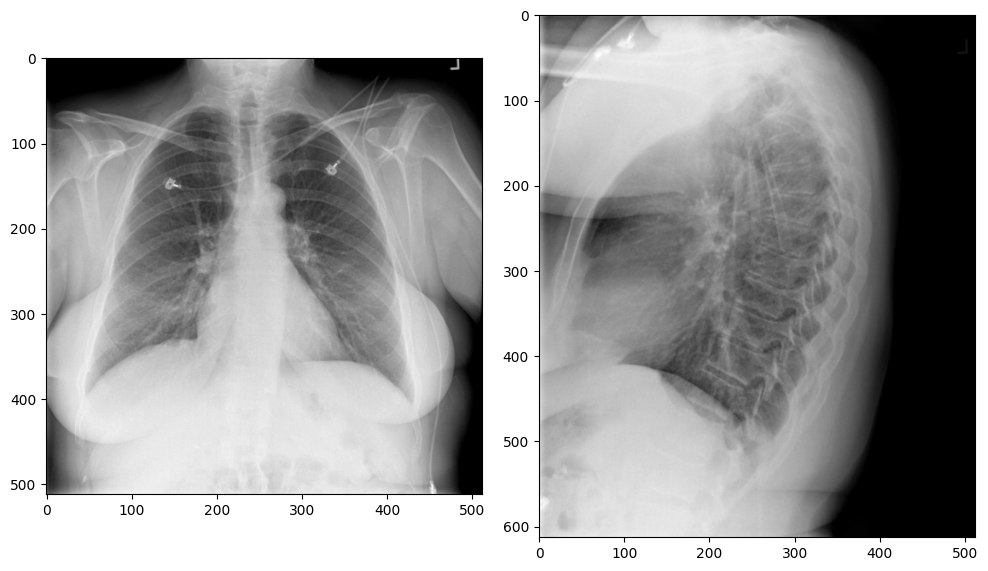

Acutal : <start> no acute cardiopulmonary abnormality <end>
Predicted:  no evidence active disease <end>
BLEU Score :- 1.4147351699132998e-231


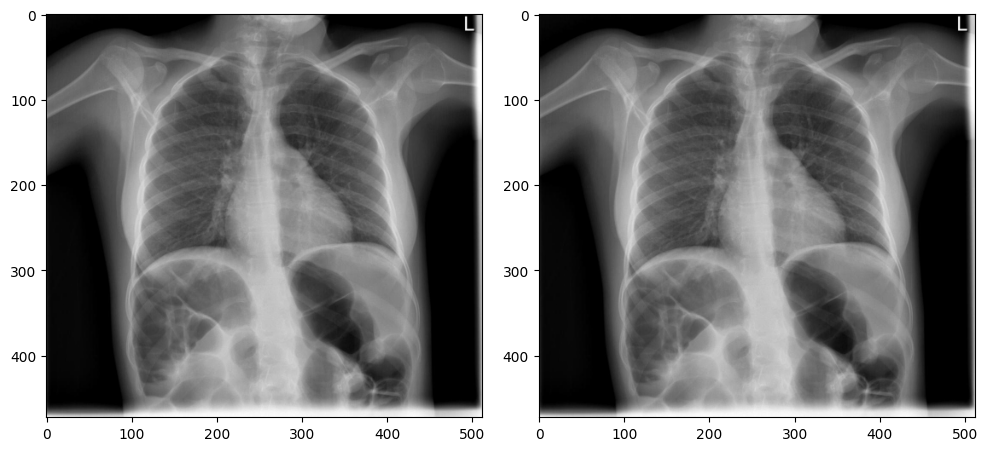

Acutal : <start> one clear lungs <end>
Predicted:  no focal emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema emphysema
BLEU Score :- 6.219450227156176e-232


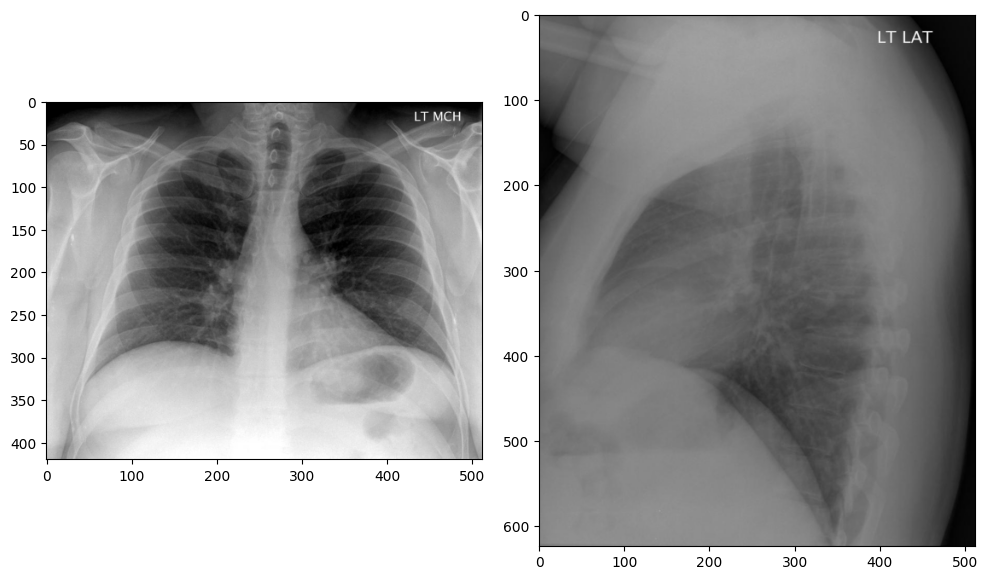

Acutal : <start> no acute active cardiac pulmonary pleural disease <end>
Predicted:  no acute cardiopulmonary abnormality <end>
BLEU Score :- 1.444619390826211e-231


Acutal : <start> improving lung volumes bibasilar atelectasis <end>
Predicted:  no acute cardiopulmonary abnormalities <end>
BLEU Score :- 1.4488496539373276e-231


Acutal : <start> stable appearing chest low lung volumes reticulonodular changes left lung base periphery left lung representing chronic inflammatory change also peripheral fibrotic appearing opacity periphery right upper lobe grossly stable no acute airspace consolidation stable mediastinal contour <end>
Predicted:  one bilateral airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace airspace
BLEU Score :- 7.189570789837425e-232


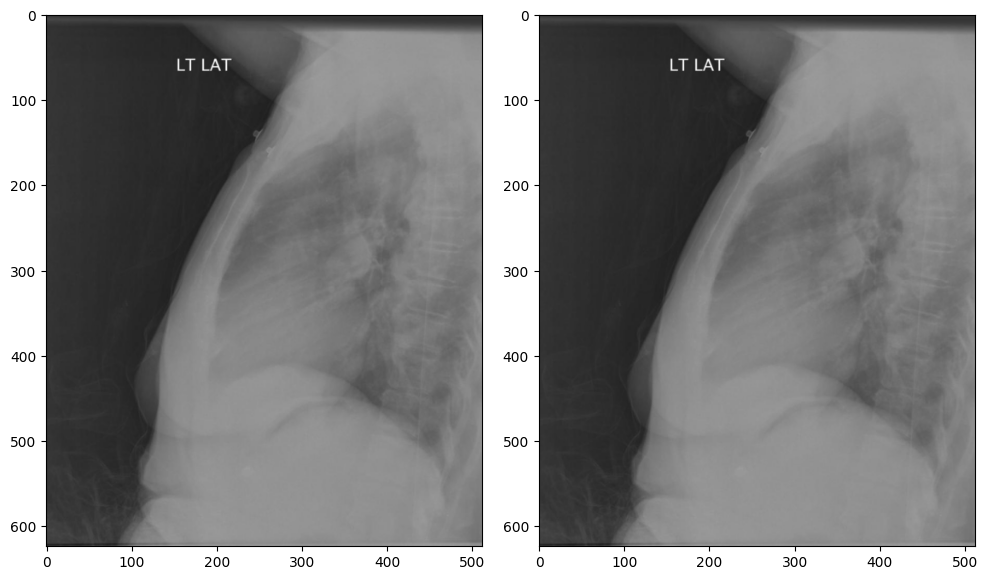

Acutal : <start> no acute cardiopulmonary disease <end>
Predicted:  no acute cardiopulmonary process <end>
BLEU Score :- 1.501620878508543e-231


Acutal : <start> one hyperexpanded lungs two otherwise normal chest <end>
Predicted:  hyperexpanded clear lungs consistent hyperexpanded clear lungs consistent hyperexpanded clear lungs consistent hyperexpanded clear lungs consistent hyperexpanded clear lungs consistent hyperexpanded clear lungs consistent hyperexpanded clear lungs consistent hyperexpanded clear lungs consistent hyperexpanded clear lungs consistent hyperexpanded clear lungs consistent hyperexpanded clear lungs consistent hyperexpanded clear lungs consistent hyperexpanded clear lungs consistent hyperexpanded clear lungs consistent hyperexpanded clear lungs consistent
BLEU Score :- 7.73131207676959e-232


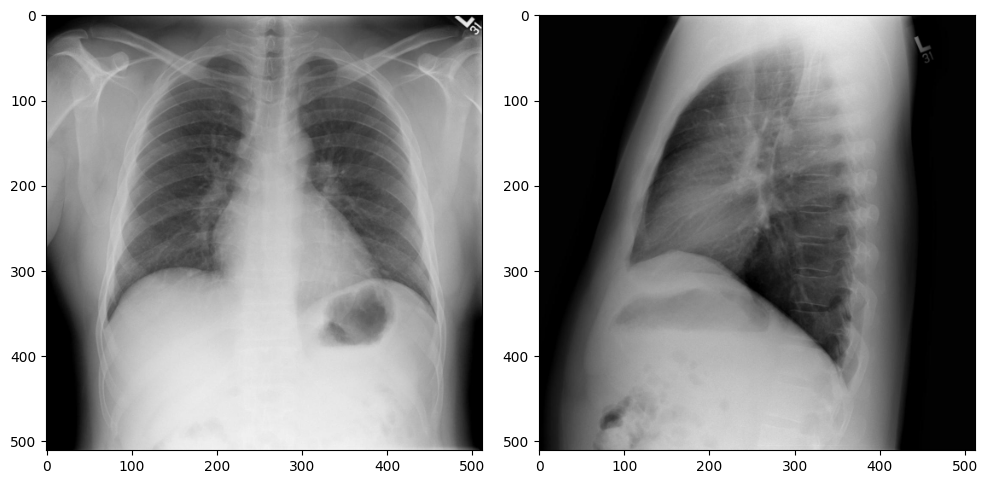

Acutal : <start> prominent interstitial markings central lungs bases may secondary low lung volumes bronchovascular crowding differential considerations include interstitial infiltrates inflammatory infectious etiology mild pulmonary edema clinical correlation recommended <end>
Predicted:  no acute cardiopulmonary findings <end>
BLEU Score :- 1.5319719891192393e-231


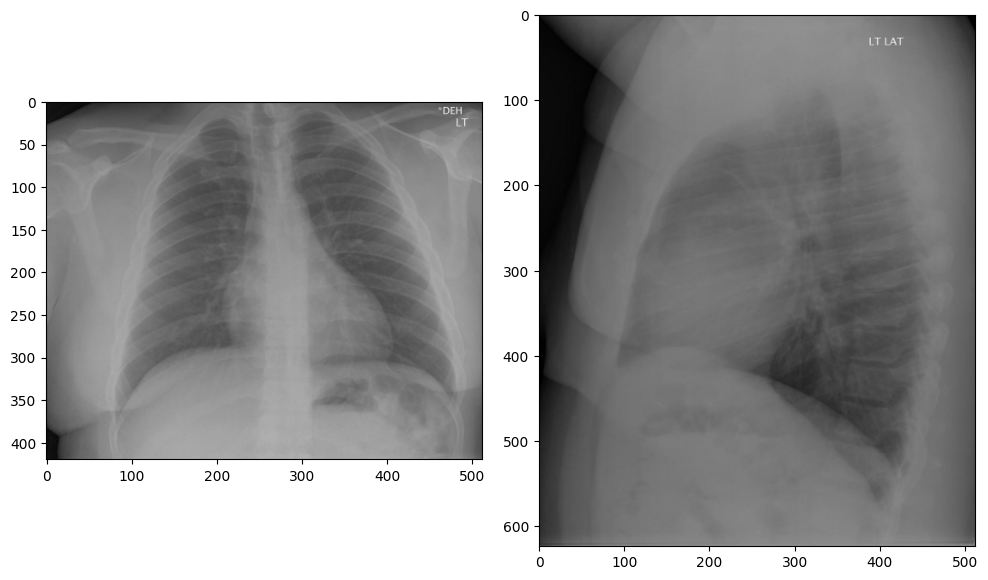

Acutal : <start> one no acute intrathoracic abnormality <end>
Predicted:  no active disease <end>
BLEU Score :- 1.5319719891192393e-231


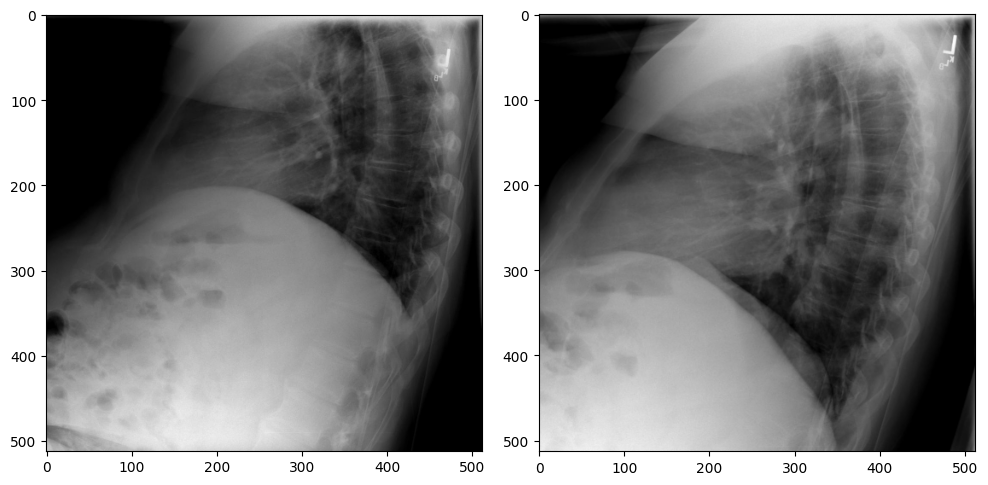

Acutal : <start> low lung volumes otherwise no definite acute findings <end>
Predicted:  no acute cardiopulmonary disease <end>
BLEU Score :- 1.4580491614797887e-231


In [190]:
for i in test.values[18:28]:
    test_img_cap(i)

# Observation :

* We observe in above predictions, our model not good perform in long sentence.

* Our model best perform in short report and wrost perform in long report.

* Some medical reports are meaning less and not useful.

* Our model good perform in short sentence.

* This is basic model, we used LSTM model with inception generated tensors, we will use attention mechanism to improve the long setence dependancy.

* We will chestXnet use pre trained model as encoder with attnetion model, we will modify pre trained for our use.